<a href="https://colab.research.google.com/github/afonsotmm/neural-network-and-knn-semantic-mapping-comparison-2d-lidar/blob/main/semantic_mapping_2d_lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
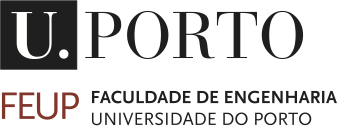   
<h1> <b>Machine Learning 2024/2025 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**Aníbal Matos** (anibal@fe.up.pt),
**Maria Inês Pereira** (maria.ines@fe.up.pt)

FEUP, Apr. 2025

---


# **Identification**

* **Group:** Project_A01_E
* **Name:** Afonso Tomás de Magalhães Mateus
* **Student Number:** 202204126

* **Name:** David Filipe Salazar Brás
* **Student Number:** 202106988


---




**Initial setup:** To download the data files, run the next cell.

In [1]:
!wget -O data-setMLproject2.zip https://www.dropbox.com/s/hnyhgqlj5lcqyqr/data-setMLproject2.zip?dl=0 --quiet
!unzip data-setMLproject2.zip -d.


Archive:  data-setMLproject2.zip
  inflating: ./data_test.csv         
  inflating: ./__MACOSX/._data_test.csv  
  inflating: ./data_test2obs.csv     
  inflating: ./__MACOSX/._data_test2obs.csv  
  inflating: ./data_train.csv        
  inflating: ./__MACOSX/._data_train.csv  


# **Main goal**

Consider the following scenario: A mobile robot aims to build a map of the environment with **semantics**, meaning that the robot should be capable to classify the objects nearby. The robot is travelling around and carries on-board a 2D LIDAR measurement device that obtains range measurements at each sample time $t=0, 0.1, 0.2, \ldots$ The following cell shows an example of the type of data:


In [2]:
import pandas as pd
df_test2obs = pd.read_csv('data_test2obs.csv', index_col=0)
df_test2obs.head(5)
#df

# By convention, zero values mean no range measurements.
# The units are:
# [m] for px and py (position of the robot)
# [m] for the LIDAR ranges

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 171,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180
0,-4.00,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.98,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.96,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.94,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.92,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note that the LIDAR measurements consist of range (distance) from the robot to a possible obstacle for each degree of direction, that is,
$$
r_t = \{r_\beta + \eta_r : \beta=-179^o, -178^o, \ldots, 0^o, \ldots, 180^o\}
$$
where $\eta_r$ is assumed to be Gaussian noise. If there is no obstacle within the direction of the laser range or if it is far away, that is, if the distance is greater than $5\,m$, by convention the range measurement is set to zero. Moreover, with a small probability, the range measurements could be corrupted with *outliers*.

The next figure shows $r_t$ as a function of the angle $\beta$ taken at time $t=1.0\,s$.


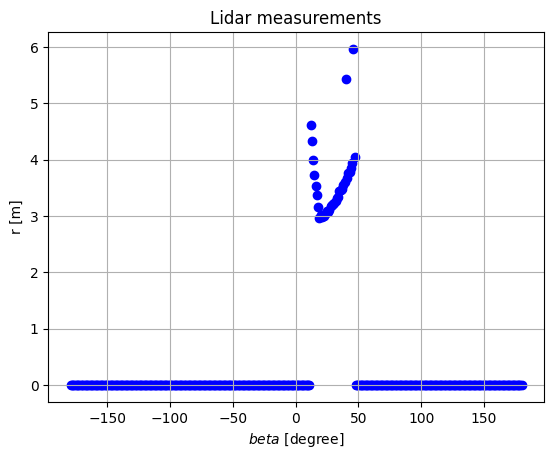

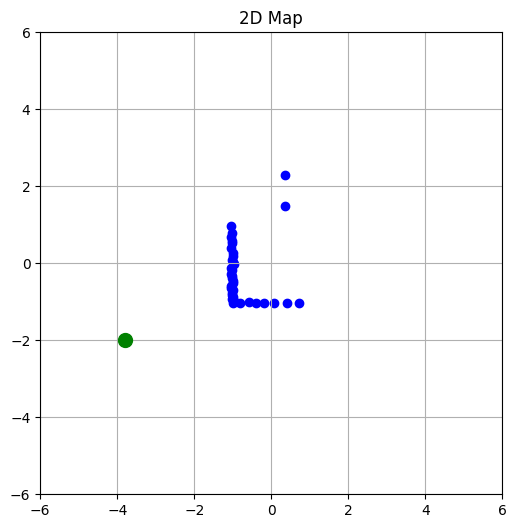

In [3]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

t=1*10 #1sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', adjustable='box')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

Note that it may be possible to have more than one object in the range of the LIDAR. \\
Here goes an example when $t=32\,s$:


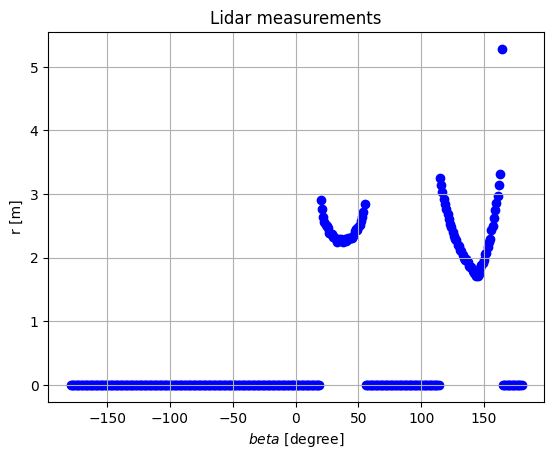

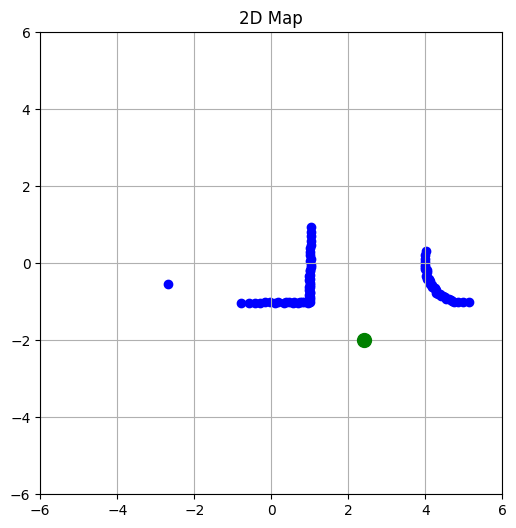

In [4]:
t=32*10 #5sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', adjustable='box')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

# **Part 1: Classification of one object**

At this point, the goal is to classify only one object that could be a square or a circle at each LIDAR snapshot. To this end, it was performed a set of 4 experiments for each obstacle (alone) where in each experiment the robot travelled during $40\,s$ with a constant speed and constant direction (horizontal line segment from left to right) from the initial position $(p_x, p_y) = (-4, \bar y)$ to the final position $(p_x, p_y) = (4, \bar y)$, where $\bar y = -4, -3, -2, -1\, m$ \\
The obstacle (circle and square) were placed at the center of the origin $(0,0)$. \\
All the experiments were combined in a unique dataset and then randomly split into two datasets: the trainning data set (70%) and the testing data set (30%). The content of each data set are displayed next.

In [ ]:
import pandas as pd
df_train = pd.read_csv('data_train.csv', index_col=0)
df_train

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180,label
0,-3.06,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.48,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.58,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-3.10,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.48,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2.60,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2236,-2.12,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2237,-2.80,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2238,1.18,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
import pandas as pd
df_test = pd.read_csv('data_test.csv', index_col=0)
df_test

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180,label
0,-3.46,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
1,0.38,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2,2.58,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
3,-2.84,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
4,-2.56,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,3.32,-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.752938,2.789123,2.869662,2.960473,3.041882,3.292784,0.0,0.0,0.0,1.0
956,3.62,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
957,2.20,-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.381054,1.557405,1.728042,2.111385,2.553902,0.000000,0.0,0.0,0.0,2.0
958,-2.98,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


Note that there is an extra column (the label column) that indicates if the obstacle is a **circle (label 1)** or a **square (label 2)**.

**1.1**
Implement a **$k$-nearest neighbor ($k$-NN)** classifier that receives the parameter $k$, the sample to classify (that are the range measurements at one snapshot), and a set of labeled training data. \\
Do not use sklearn or similar packages (use the results of notebook #7).

In [ ]:
# To complete - Done -

X_train = df_train.iloc[:, np.arange(2,362,1)].values
Y_train = df_train["label"].values
data_train = df_train.iloc[:, np.arange(2,363,1)].values  #it also includes the label

# KNN

def vector2norm(x, data):
  npoints = data.shape[0]
  distances = np.zeros(npoints)
  features_data = data[:,:-1] # we don't want to take into account the label's column in the dist. calculation - just the actual measured data.
  for i in range(npoints) :
     distances[i] = np.linalg.norm(x-features_data[i])
  return distances


def kNN_classifier(k,x,data):
  npoints = data.shape[0]
  # compute distance to training points
  dist = vector2norm(x,data)
  # sort along increasing distances
  ind = np.argsort(dist)
  # select the first k points
  classes = data[:,360] # 360 because the data_train matrix, doesn't take into account
                        # the 3 first columns, so the labels are in the column 360.

  classes_sorted = classes[ind]
  # determine class with more element in the k neighborhood
  c1 = 0
  c2 = 0
  for i in range(k):
    if classes_sorted[i]==1:
      c1 +=1
    else:
      c2 +=1
  if c1>c2:
    return 1
  else:
    return 2


**1.2**
Test the $k$-NN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy for $k=1,3,5,7,9$ \\
Note that accuracy is defined as
$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives.


In [ ]:
# To complete - Done -

k = 3

# ------------------------------------------------------------------------------
#                               Train
# ------------------------------------------------------------------------------

# Create combined dataset with labels
data_train = np.append(X_train, np.reshape(Y_train, (len(Y_train), 1)), axis=1)

classification = []
for t in range(len(X_train)):
    # Remove the t-th example from the training set
    data_train_temp = np.delete(data_train, t, axis=0)

    # Classify using the rest of the training set
    classification.append(kNN_classifier(k, X_train[t], data_train_temp))

# Convert to numpy array and compute accuracy
classification = np.array(classification)
acc = np.mean(classification == Y_train)

# Just to compare w/the testing data
print(f"Acc w/Training Data: {100.0 * acc:.2f}%")

# ------------------------------------------------------------------------------
#                               Test
# ------------------------------------------------------------------------------

# Let's check for the testing data
X_test = df_test.iloc[:, np.arange(2,362,1)].values
Y_test = df_test["label"].values

# Create combined dataset with labels
data_test = np.append(X_test, np.reshape(Y_test, (len(X_test), 1)), axis=1)

classification = []
for t in range(len(X_test)):
    classification.append(kNN_classifier(k, X_test[t], data_test))

# Convert to numpy array and compute accuracy
classification = np.array(classification)
acc = np.mean(classification == Y_test)

print(f"Acc w/Testing Data: {100.0 * acc:.2f}%")

# ------------------------------------------------------------------------------
#                               RESULTS
# ------------------------------------------------------------------------------

#  k = 1
#     - Training Data: 99.60 %
#     - Testing Data:  100.0 %

#  k = 2
#     - Training Data: 99.20 %
#     - Testing Data:  99.48 %

#  k = 3
#     - Training Data: 98.97 %
#     - Testing Data:  100.0 %

#  k = 4
#     - Training Data: 98.79 %
#     - Testing Data:  99.17 %

#  k = 5
#     - Training Data: 98.71 %
#     - Testing Data:  99.17 %

#  k = 6
#     - Training Data: 99.24 %
#     - Testing Data:  98.65 %

#  k = 7
#     - Training Data: 99.24 %
#     - Testing Data:  98.65 %

#  k = 8
#     - Training Data: 99.42 %
#     - Testing Data:  97.40 %

#  k = 9
#     - Training Data: 99.42 %
#     - Testing Data:  97.29 %

# k = 100
#     - Training Data: 60.45 %
#     - Testing Data:  56.56 %

# k = 200
#     - Training Data: 60.31 %
#     - Testing Data:  52.40 %

# k = 960
#     - Training Data: 56.52%
#     - Testing Data:  50.00%

#  Important Remarks:
#
# - Although the highest accuracy values were obtained for k = 1 and k = 3, it is
# important to consider that for small values of k (e.g., as k approaches 0), the
# classification becomes significantly more sensitive to noise.
#
# - On the other hand, using high values of k (relative to the number of samples)
# leads to a substantial overlap between classes, which results in the inclusion
# of many neighbors from incorrect classes, thus reducing the overall performance.
#
# - It is also advisable to avoid choosing values of k that are multiples of the
# number of classes, as this increases the likelihood of classification ties, which
# can negatively affect the classifier's reliability.
#
# - The result with k = 960 is expected, because when k equals N, the classification
# only depends on the proportion of each class in the dataset. In this case, the
# Testing Data contains an equal number of samples from each class.

Acc w/Training Data: 98.97%
Acc w/Testing Data: 100.00%


#   **k-NN Classifier Results**

##   Accuracy for Different Values of k

| k   | Training Accuracy (%) | Testing Accuracy (%) |
|-----|------------------------|-----------------------|
| 1   | 99.60                  | 100.00                |
| 2   | 99.20                  | 99.48                 |
| 3   | 98.97                  | 100.00                |
| 4   | 98.79                  | 99.17                 |
| 5   | 98.71                  | 99.17                 |
| 6   | 99.24                  | 98.65                 |
| 7   | 99.24                  | 98.65                 |
| 8   | 99.42                  | 97.40                 |
| 9   | 99.42                  | 97.29                 |
| 100 | 60.45                  | 56.56                 |
| 200 | 60.31                  | 52.40                 |
| 960 | 56.52                  | 50.00                 |

---

##   **Important Remarks**

- Although the highest accuracy values were obtained for **k = 1** and **k = 3**, it's important to consider that for **small values** of *k* (as *k* approaches 0), the classification becomes significantly more sensitive to **noise**. Even though both k = 1 and k = 3 achieved 100% testing accuracy, k = 3 is more reliable due to its lower sensitivity to noise.

- On the other hand, using **high values of *k*** (relative to the number of samples) leads to a substantial **overlap between classes**, which results in the inclusion of many neighbors from incorrect classes, thus reducing the overall performance.

- It is also advisable to avoid choosing values of *k* that are **multiples of the number of classes**, as this increases **classification ties**, which can negatively affect the classifier's reliability.

- The result with **k = 960** is expected, because when *k = N*, the classification only depends on the **proportion of each class** in the dataset. In this case, the testing set contains an **equal number of samples** from each class.
---

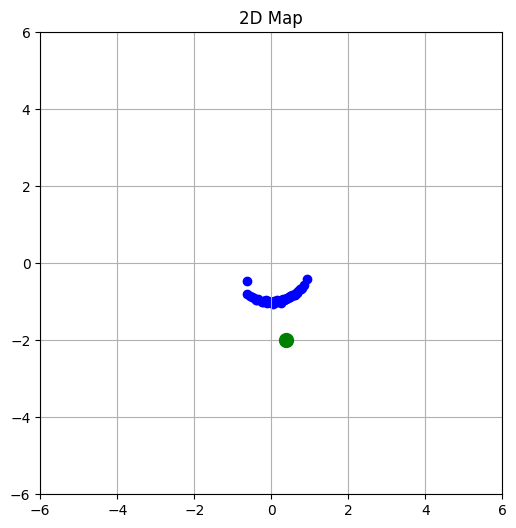

Real Label: Circle
Predicted Label: Circle



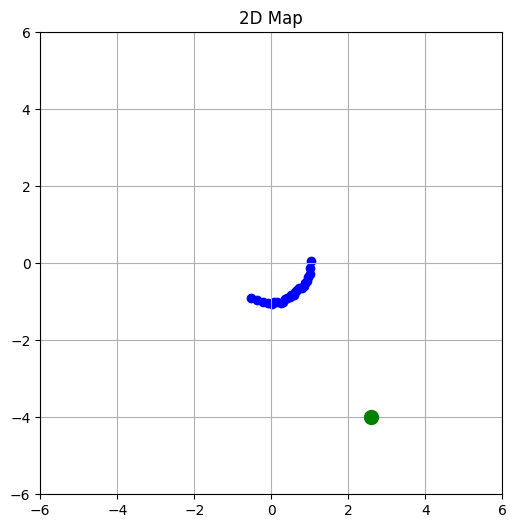

Real Label: Circle
Predicted Label: Circle



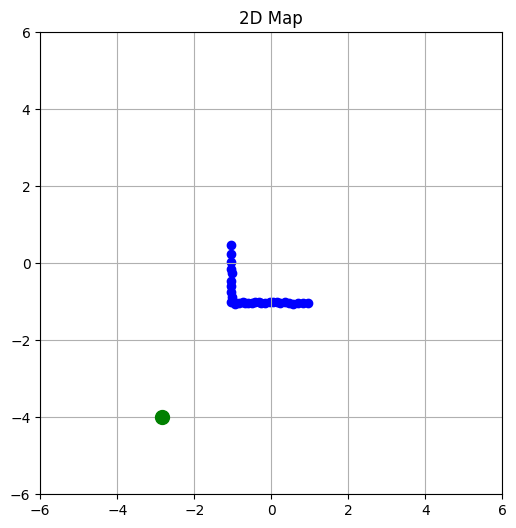

Real Label: Square
Predicted Label: Square



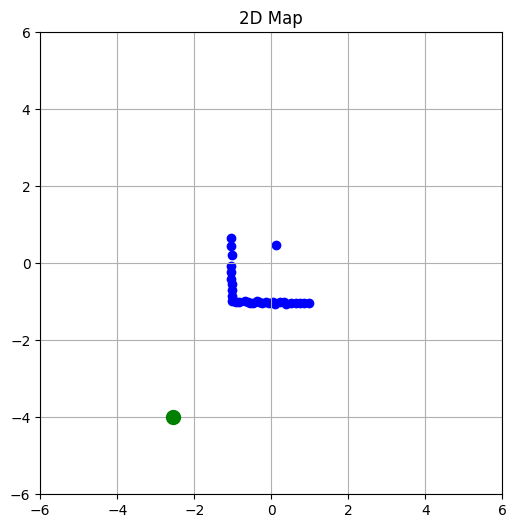

Real Label: Square
Predicted Label: Square



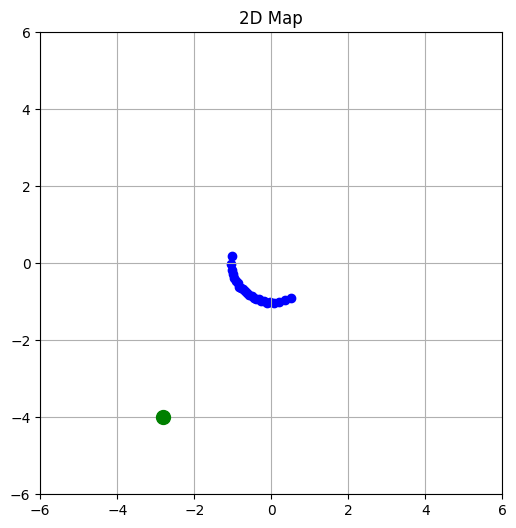

Real Label: Circle
Predicted Label: Circle



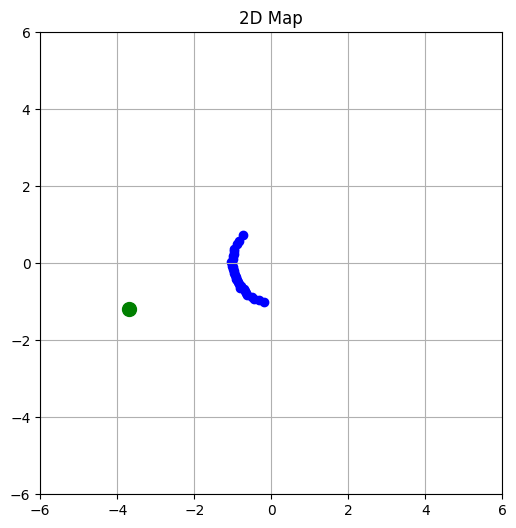

Real Label: Circle
Predicted Label: Circle



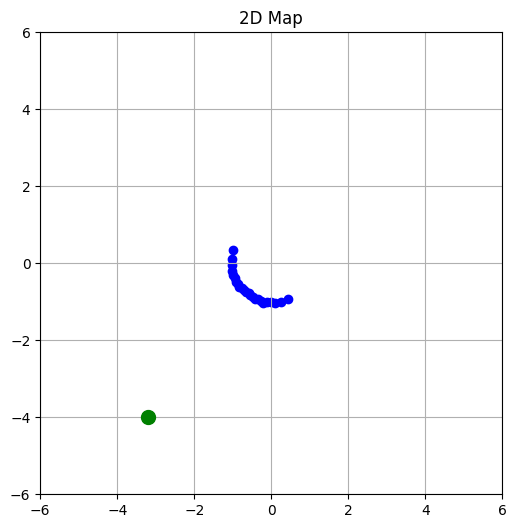

Real Label: Circle
Predicted Label: Circle



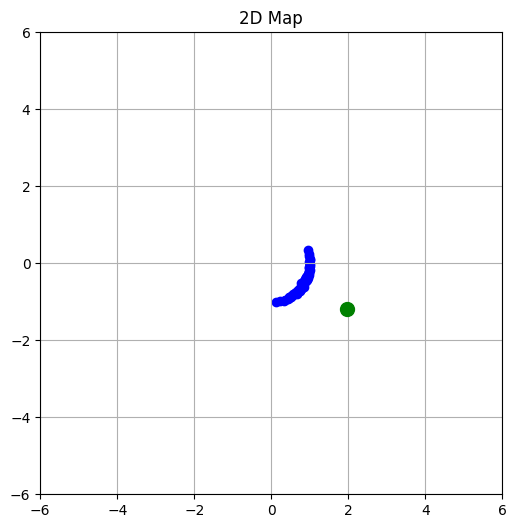

Real Label: Circle
Predicted Label: Circle



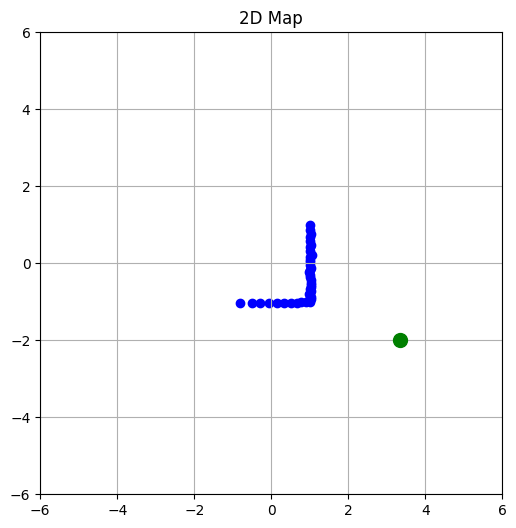

Real Label: Square
Predicted Label: Square



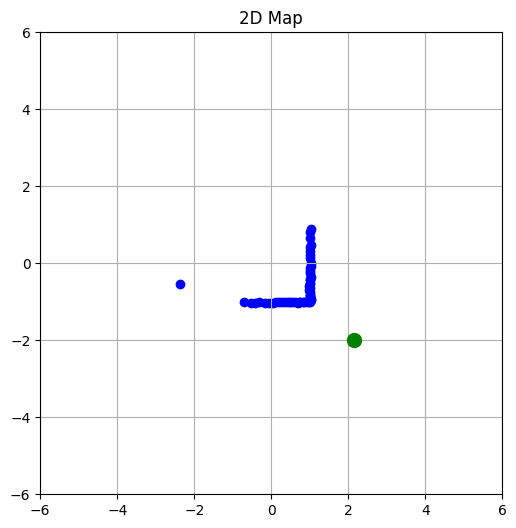

Real Label: Square
Predicted Label: Square



In [ ]:
# ------------------------------------------------------------------------------
#                               Nice Plots
# ------------------------------------------------------------------------------

Lidar_range = df_test.iloc[:, np.arange(2,362,1)].values
px = df_test["px"].values
py = df_test["py"].values

for i in range(10):
  t = (i+1)*1
  angle = np.linspace(-179, 180, num=360)

  x_o, y_o = [], []
  for i in range(len(Lidar_range[t])):
    if Lidar_range[t][i] > 0:
      x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
      y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

  fig, ax = plt.subplots(figsize=(6,6))
  ax.set_aspect('equal', adjustable='box')
  xdim, ydim = 5, 5
  plt.xlim(-xdim-1,xdim+1)
  plt.ylim(-ydim-1,ydim+1)
  plt.plot(px[t], py[t], 'g.', ms=20)
  plt.grid()

  plt.scatter(x_o, y_o, color='b')
  plt.title('2D Map');
  plt.show()

  if Y_test[t] == 2:
    print(f"Real Label: Square")
  elif Y_test[t] == 1:
    print(f"Real Label: Circle")

  if classification[t] == 2:
    print(f"Predicted Label: Square\n")
  elif classification[t] == 1:
    print(f"Predicted Label: Circle\n")
  else:
    print(f"Predicted Label: Error\n")


**1.3**
Implement an Artificial Neural Network (ANN) of the type multi-layer perceptron (MLP) with
1. an input layer that receives the first 10 nonzero range measurements (for each snapshot);  
2. one hidden layer with 5 neurons with activation functions of the type ReLU (rectified linear unit);
3. an output layer with 1 neuron with a sigmoid activation function;

4. a loss function of the type mean square error.

Train the ANN using the `data_train.csv` set. \\
**Do not use** PyTorch, TensorFlow or similar packages (check notebook #8). \\
**Tip:** It is important to shuffle the training data. You may get better results with non constant learning rate. A final loss below 0.05 is good!


In [ ]:
# To complete

import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split

N_INPUTS = 10  #Number of inputs

def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def sigmoid(x):
  return 1/(1+np.exp(-x))

def deriv_sigmoid(x):
  s = sigmoid(x)
  return (s*(1-s))

# ReLu activation function:
def relu(x):
  return np.maximum(x, 0)

# Derivative of ReLu
def deriv_relu(x):
  return (x > 0).astype(float)


class NeuralNetwork:
  '''
  Structure of the neural network:
    - N_INPUTS inputs
    - a hidden layer with 5 neurons (h1, h2, h3, h4, h5)
    - an output layer with 1 neuron (o1)
  '''
  def __init__(self):
    # Hidden Layer Biases
    self.b1 = np.random.random()
    self.b2 = np.random.random()
    self.b3 = np.random.random()
    self.b4 = np.random.random()
    self.b5 = np.random.random()

    # Output Layer Bias
    self.bo = np.random.random()

    # Hidden Layer Weigths
    self.wi1 = np.random.random(N_INPUTS)
    self.wi2 = np.random.random(N_INPUTS)
    self.wi3 = np.random.random(N_INPUTS)
    self.wi4 = np.random.random(N_INPUTS)
    self.wi5 = np.random.random(N_INPUTS)

    # Output Layer Weights
    self.w1o, self.w2o, self.w3o, self.w4o, self.w5o = np.random.random(5)


  def feedforward(self, x, diplay=False):
    '''
    - x is a numpy array with N_INPUTS elements.
    '''

    # Hidden layer Weighted Sum
    self.sum_h1 = np.dot(self.wi1, x) + self.b1
    self.sum_h2 = np.dot(self.wi2, x) + self.b2
    self.sum_h3 = np.dot(self.wi3, x) + self.b3
    self.sum_h4 = np.dot(self.wi4, x) + self.b4
    self.sum_h5 = np.dot(self.wi5, x) + self.b5

    # Hidden Layer Activation
    self.h1 = relu(self.sum_h1)
    self.h2 = relu(self.sum_h2)
    self.h3 = relu(self.sum_h3)
    self.h4 = relu(self.sum_h4)
    self.h5 = relu(self.sum_h5)

    # Output layer Weighted Average
    self.sum_o1 = self.w1o*self.h1 + self.w2o*self.h2 + self.w3o*self.h3 + self.w4o*self.h4 + self.w5o*self.h5 + self.bo


    # Output Layer Activation
    self.o1 = sigmoid(self.sum_o1)

    return self.o1



  def train(self, data, y_trues, learn_rate = 0.1, epochs = 500):
    '''
    - data is a (n x N_INPUTS) numpy array, n = # of samples in the dataset.
    - y_trues is a numpy array with n elements.
      Elements in y_true correspond to those in data.
    '''
    loss_prev = 10000  #loss_prev is the loss of the previous iteration
    for epoch in range(epochs):
      for x, y_true in zip(data, y_trues):

        # *************************************************
        # 1. Feedforward Step
        y_pred = self.feedforward(x, epoch == epochs)

        # *************************************************
        # 2. Backpropagation Step

        # Partial derivatives.
        d_L_d_ypred = -2 * (y_true - y_pred)

        # Output Layer:  Neuron o1

        d_ypred_d_w1o = self.h1 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w2o = self.h2 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w3o = self.h3 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w4o = self.h4 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w5o = self.h5 * deriv_sigmoid(self.sum_o1)

        d_ypred_d_h1 = self.w1o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h2 = self.w2o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h3 = self.w3o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h4 = self.w4o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h5 = self.w5o * deriv_sigmoid(self.sum_o1)

        d_ypred_d_bo = deriv_sigmoid(self.sum_o1)

        # Hidden Layer: Neuron h1
        d_h1_d_wi1 = x * deriv_relu(self.sum_h1)
        d_h1_d_b1 = deriv_relu(self.sum_h1)

        # Hidden Layer: Neuron h2
        d_h2_d_wi2 = x * deriv_relu(self.sum_h2)
        d_h2_d_b2 = deriv_relu(self.sum_h2)

        # Hidden Layer: Neuron h3
        d_h3_d_wi3 = x * deriv_relu(self.sum_h3)
        d_h3_d_b3 = deriv_relu(self.sum_h3)

        # Hidden Layer: Neuron h4
        d_h4_d_wi4 = x * deriv_relu(self.sum_h4)
        d_h4_d_b4 = deriv_relu(self.sum_h4)

        # Hidden Layer: Neuron h5
        d_h5_d_wi5 = x * deriv_relu(self.sum_h5)
        d_h5_d_b5 = deriv_relu(self.sum_h5)


        # *************************************************
        # 3. Gradient Descent
        # Output Layer:  Neuron o1
        self.w1o -= learn_rate * d_L_d_ypred * d_ypred_d_w1o
        self.w2o -= learn_rate * d_L_d_ypred * d_ypred_d_w2o
        self.w3o -= learn_rate * d_L_d_ypred * d_ypred_d_w3o
        self.w4o -= learn_rate * d_L_d_ypred * d_ypred_d_w4o
        self.w5o -= learn_rate * d_L_d_ypred * d_ypred_d_w5o

        self.bo -= learn_rate * d_L_d_ypred * d_ypred_d_bo

        # Hidden Layer: Neuron h1
        self.wi1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_wi1
        self.b1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_b1

        # Hidden Layer: Neuron h2
        self.wi2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_wi2
        self.b2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_b2

        # Hidden Layer: Neuron h3
        self.wi3 -= learn_rate * d_L_d_ypred * d_ypred_d_h3 * d_h3_d_wi3
        self.b3 -= learn_rate * d_L_d_ypred * d_ypred_d_h3 * d_h3_d_b3

        # Hidden Layer: Neuron h4
        self.wi4 -= learn_rate * d_L_d_ypred * d_ypred_d_h4 * d_h4_d_wi4
        self.b4 -= learn_rate * d_L_d_ypred * d_ypred_d_h4 * d_h4_d_b4

        # Hidden Layer: Neuron h5
        self.wi5 -= learn_rate * d_L_d_ypred * d_ypred_d_h5 * d_h5_d_wi5
        self.b5 -= learn_rate * d_L_d_ypred * d_ypred_d_h5 * d_h5_d_b5

      # *************************************************
      # 4. Performance assessment (per epoch)
      if epoch % 5 == 0:
        y_preds = np.apply_along_axis(self.feedforward, 1, data, False)
        loss = mse_loss(y_trues, y_preds)
        if epoch % 200 == 0:
          print(f"Epoch {epoch} --> Loss: {loss}")
        if loss - loss_prev > 0.0005:  #if loss did not decrease, let's decrease the learn_rate
          if learn_rate > 0.002:
            learn_rate = learn_rate*.9  #decrease 90% of the previous value
          print("I'm at epoch", epoch, "with new learn_rate: ", learn_rate)
        loss_prev = loss

# ------------------------------------------------------------------------------

# Create the ANN
ann_model = NeuralNetwork()

X_train = df_train.iloc[:, np.arange(2,362,1)].values
Y_train = df_train["label"].values

# Build the Trainingset (with the first nonzero N_INPUTS ranges)
filtered_X = np.zeros([len(Y_train), N_INPUTS])
for t in range(len(Y_train)):
  j=0
  for i in range(360):
    if X_train[t][i] > 0:
      if j < N_INPUTS:
        filtered_X[t][j] = X_train[t][i]
        j +=1

# Trainingset: here the labels are 0 or 1
filtered_Y = Y_train-1

train_set_X, test_set_X, train_set_Y, test_set_Y = train_test_split(filtered_X, filtered_Y, test_size=0.3, random_state=42)

# Train the ANN
ann_model.train(train_set_X, train_set_Y, learn_rate = 0.1, epochs = 1000)

Epoch 0 --> Loss: 0.49262096317089343
I'm at epoch 60 with new learn_rate:  0.09000000000000001
I'm at epoch 90 with new learn_rate:  0.08100000000000002
I'm at epoch 95 with new learn_rate:  0.07290000000000002
I'm at epoch 125 with new learn_rate:  0.06561000000000002
I'm at epoch 145 with new learn_rate:  0.05904900000000002
I'm at epoch 165 with new learn_rate:  0.05314410000000002
I'm at epoch 180 with new learn_rate:  0.04782969000000002
I'm at epoch 190 with new learn_rate:  0.043046721000000024
Epoch 200 --> Loss: 0.1516619194255658
I'm at epoch 210 with new learn_rate:  0.03874204890000002
I'm at epoch 215 with new learn_rate:  0.03486784401000002
I'm at epoch 255 with new learn_rate:  0.03138105960900001
I'm at epoch 275 with new learn_rate:  0.028242953648100012
I'm at epoch 350 with new learn_rate:  0.025418658283290013
I'm at epoch 365 with new learn_rate:  0.022876792454961013
I'm at epoch 380 with new learn_rate:  0.020589113209464913
I'm at epoch 395 with new learn_rate

**1.4**
Test the ANN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy. Write in a brief sentence of the main conclusions about the classifiers (k-NN and ANN) until this point.

In [ ]:
# To complete
X_test = df_test.iloc[:, np.arange(2,362,1)].values
Y_test = df_test["label"].values


#Evaluation with the Training set
classification = []
for t in range(len(train_set_X)):
  classification.append(ann_model.feedforward(train_set_X[t]) )
classification = np.array(classification)
error_clas = 0

for t in range(len(classification)):
  if (classification[t] >= 0.5) and (train_set_Y[t]==0):
    error_clas += 1
  if (classification[t] < 0.5) and (train_set_Y[t]==1):
    error_clas += 1

print("Number of misclassified samples in the training data: ", error_clas, "in", len(Y_train))
acc = 1 - error_clas/len(Y_train)
print(f"Accuracy of the model: {100.0*acc:4.2f}%")


# Evaluation with Test_set --------------------------------------------------

evaluation = []
for t in range(len(test_set_X)):
  evaluation.append( ann_model.feedforward(test_set_X[t]) )
evaluation = np.array(evaluation)
error_ev = 0

for t in range(len(evaluation)):
  if (evaluation[t] >= 0.5) and (test_set_Y[t]==0):
    error_ev += 1
  if (evaluation[t] < 0.5) and (test_set_Y[t]==1):
    error_ev += 1

print("Number of misclassified samples in the Test data: ", error_ev, "in", len(Y_test))
acc = 1 - error_ev/len(Y_test)
print(f"Accuracy of the model: {100.0*acc:4.2f}%")


Number of misclassified samples in the training data:  92 in 2240
Accuracy of the model: 95.89%
Number of misclassified samples in the Test data:  38 in 960
Accuracy of the model: 96.04%


# Conclusões para ANN
O uso do ajuste contínuo da learning rate fornece resultantes consistentemente melhores. Isto porque, quando o valor do gradiente de um determinado parâmetro se encontra relativamente próximo do mínimo da função, qualquer step minimamente grande é suficiente para afastar o resultado da iteração para mais longe do mínimo.

Diminuir a learning rate faz com que cada step do algoritmo de otimização seja menor. Embora isto resulte numa evolução mais lenta, é também mais *cautelosa*, e tende a culminar em resultados mais satisfatórios.



# **Part 2: Classification of two objects**

We would like now to use the previous ANN classifier to the data in `data_test2obs.csv` that may have two objects at the same snapshot. The idea is to before send the range measurements to the classifier, apply first a k-means at each snapshot to separate the data into two sub-sets such that each sub-set only contains data of one object. Then, send each subset of data to the ANN classifier.

**2.1**
Implement the k-means algorithm and test it for two snapshots **converted to the 2D map** (that is, the input data for the k-means is the 2D map) of the dataset `data_test2obs.csv` for
1. $t=1\,s$ (which has only one object) and
2. for $t=32\,s$ (which has 2 objects).

What can you conclude? \\
Do not use sklearn or similar packages (use the results of notebook #10).


**k-means algorithm**

In [ ]:
# To complete - Done -

def kmeans_func(X_func, K_func, show_plot=0, ini_method=0):
  '''
    X_func are sample points;
    K_func is the number of clusters;
    showplot 0/1 - not / show centroid evolution over iterations;
    ini_method 0/1 - ini centroids 0=> with random within data bounderies or 1=>from the initial points (risky!)
  '''

  cluster = np.zeros(X_func.shape[0], dtype=int)
  centr_ini = []
  if ini_method:  # 1 is points, 0 is random
      # Initial centroids are sample points (risky!)
      for i in range(K_func):
          centr_ini.append(X_func[i])
  else:
      # Non absurd Random Initial Centroids
      max0 = max(X_func[:,0])
      min0 = min(X_func[:,0])
      max1 = max(X_func[:,1])
      min1 = min(X_func[:,1])

      for i in range(K_func):
          centr_ini.append([random.uniform(min0,max0),random.uniform(min1,max1)])

  iter = 0
  diff = 1
  centroids = centr_ini
  centr_list = [centroids]

  # Convert centroids to NumPy array
  centroids = np.array(centroids)
  centr_list = [centroids.copy()]

  while diff > 0 and iter < 100:
      iter += 1
      diff = 0
      old_centroids = centroids.copy()

      for i in range(X_func.shape[0]):
          dist = [np.linalg.norm(X_func[i] - centroid) for centroid in centroids] #dist = [d0, d1, ..., dn], where d0 - distance to the centroid '0'
          cluster[i] = np.argmin(dist)

      for k in range(K_func):
          points_in_cluster = X_func[cluster == k]
          if len(points_in_cluster) > 0:
              centroids[k] = np.mean(points_in_cluster, axis=0)
          distance = np.linalg.norm(centroids[k] - old_centroids[k])
          diff += distance

      centr_list.append(centroids.copy())

      if show_plot:
          fig, ax = plt.subplots(figsize=(6,6))
          ax.set_aspect('equal', adjustable='box')
          xdim, ydim = 5, 5
          plt.xlim(-xdim-1,xdim+1)
          plt.ylim(-ydim-1,ydim+1)
          plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
          plt.grid()

          plt.scatter(X_func[:, 0], X_func[:, 1], c=cluster, cmap='viridis', label='Data Points')
          plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label=f'Centroids Iter {iter}')
          plt.title(f'2D Map iteration {iter}');
          plt.show()

  return centroids, cluster

**One Object Case with k = 1**

Analized scene


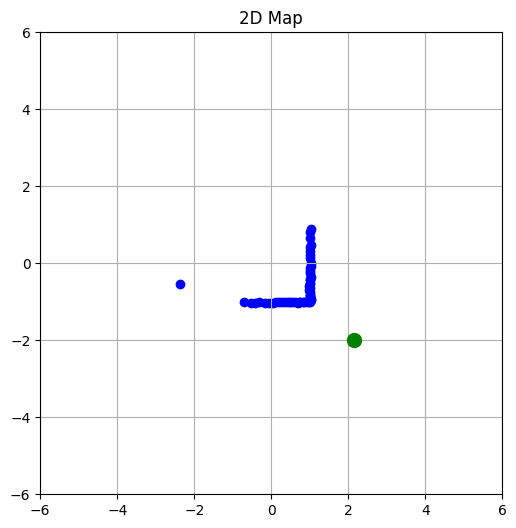


Random Inital Centroids


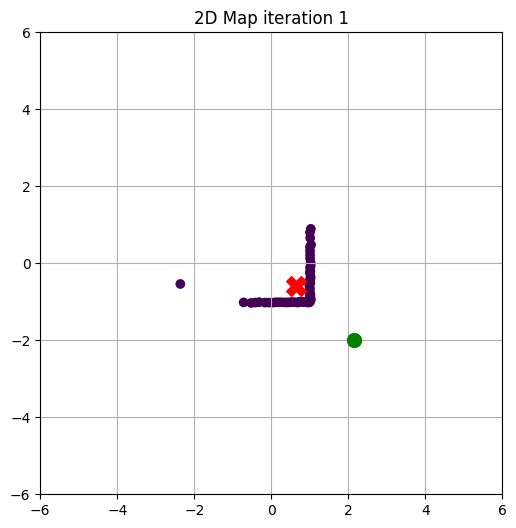

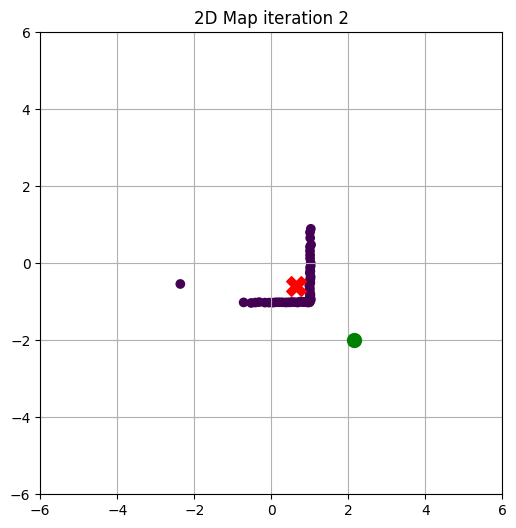

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Static Initial Centroids


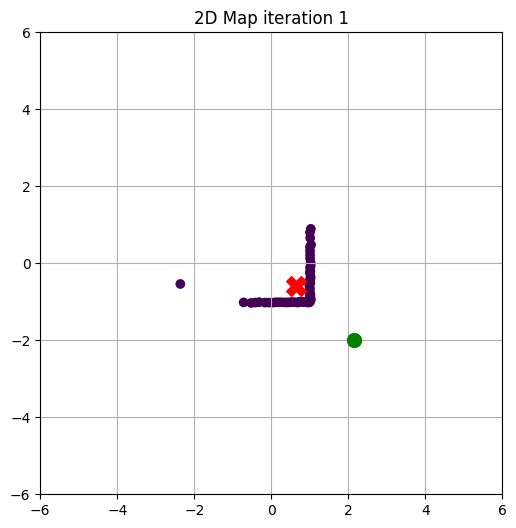

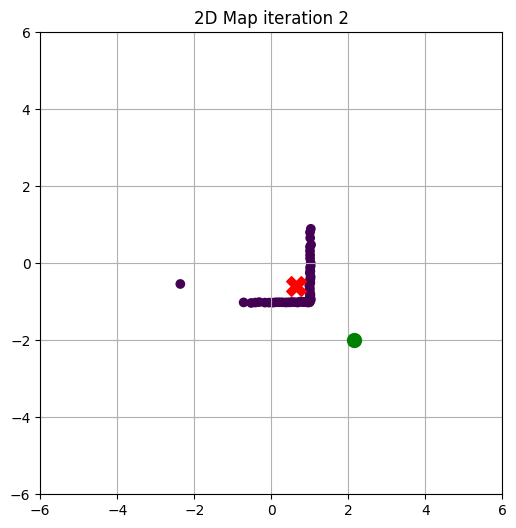

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# ------------------------------------------------------------------------------- #
#                           One Object Case (t = 1 * 10)
# ------------------------------------------------------------------------------- #
#Build the cloud points in 2D map
x_o, y_o = [], []

t=1*10

for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T

print("Analized scene")

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', adjustable='box')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()
plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

print("\nRandom Inital Centroids")

# Using Random initial centroids
centr, clust = kmeans_func(X, 1, show_plot=1, ini_method=1)
print(clust)

print("\nStatic Initial Centroids")

# Using Static initial centroids
centr, clust = kmeans_func(X, 1, show_plot=1, ini_method=1)
print(clust)

**Two Objects Case with k = 2**


Analized Scene


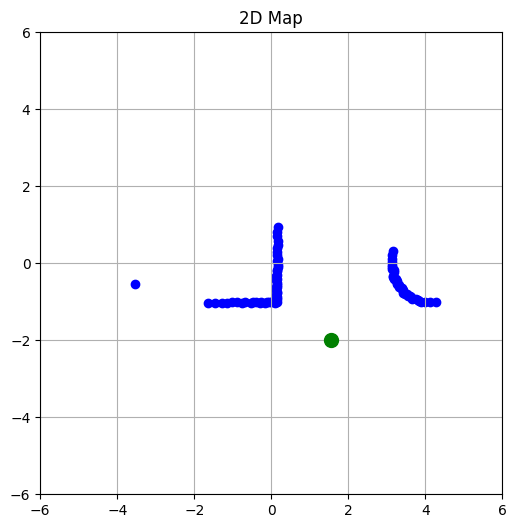


Random Inital Centroids


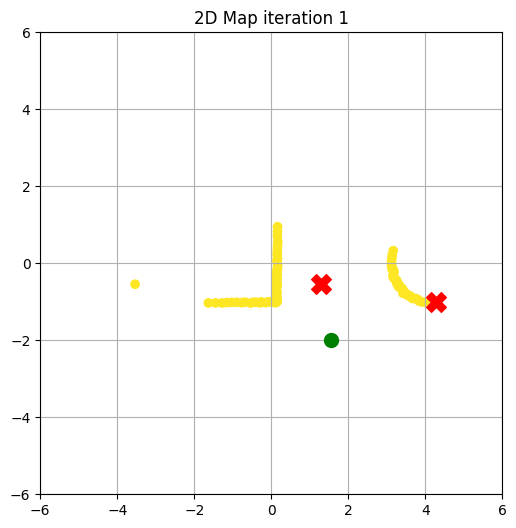

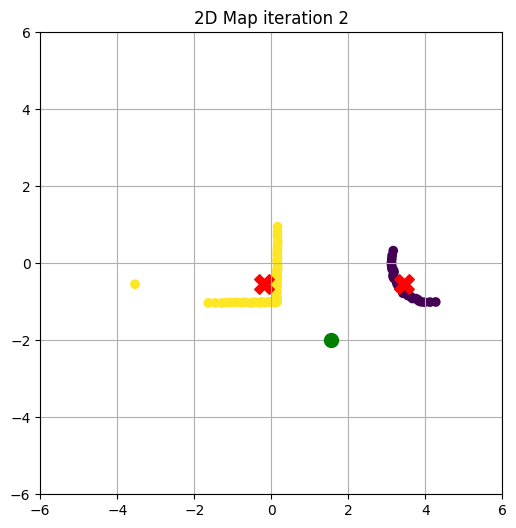

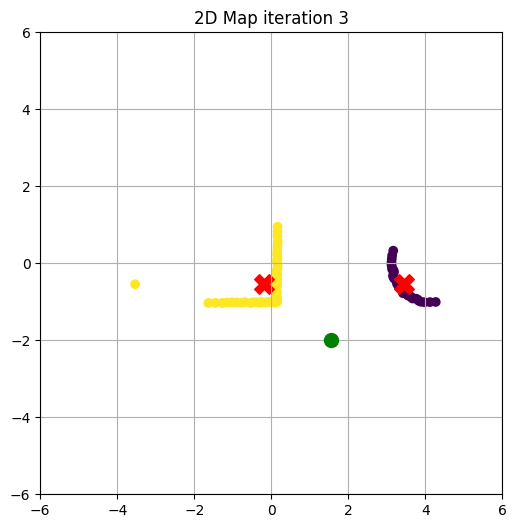

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]

Static Initial Centroids


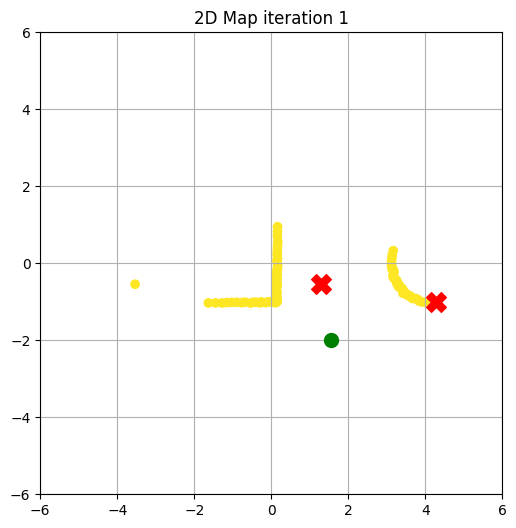

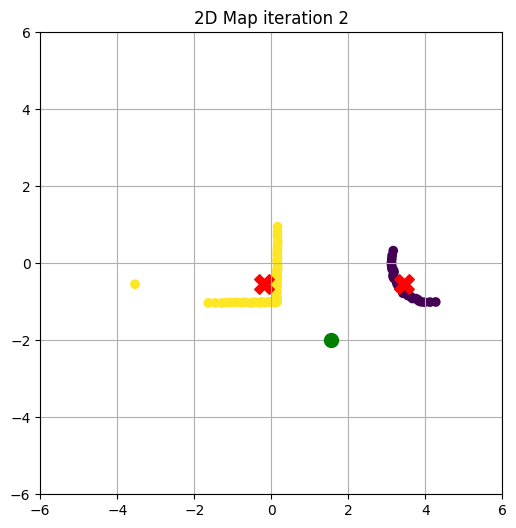

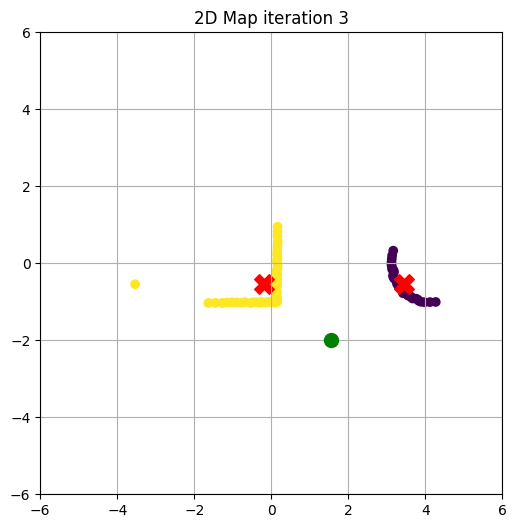

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# ------------------------------------------------------------------------------- #
#                           One Object Case (t = 32 * 10)
# ------------------------------------------------------------------------------- #
#Build the cloud points in 2D map
x_o, y_o = [], []
Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values

t=32*10

for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T

print("\nAnalized Scene")

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', adjustable='box')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()
plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

print("\nRandom Inital Centroids")

# Using Random initial centroids
centr, clust = kmeans_func(X, 2, show_plot=1, ini_method=1)
print(clust)

print("\nStatic Initial Centroids")

# Using Static initial centroids
centr, clust = kmeans_func(X, 2, show_plot=1, ini_method=1)
print(clust)

**2.2**
Using the previous results,
1. implement a method to automatically identify for each snapshot if it has 1 or 2 objects;
2. build a new test set with all the data in `data_test2obs.csv`, but now the new test set only has 1 object in each snapshot (and therefore this data set has more lines);
3. test this new data set using the ANN classifier.

Plot the position of the robot and the classified objects for some snapshots. What are the main conclusions?

**SSE function**

In [ ]:
def SSE(X, centroids, cluster):
  '''
    returns the Sum of Squared Error
    X are the 2D points
    centroids are the cluster centers
    cluster is the cluster that each data point belongs to
  '''
  sum = 0
  for i, val in enumerate(X):
    sum += np.sqrt((centroids[cluster[i], 0]-val[0])**2 +(centroids[cluster[i], 1]-val[1])**2)  ####
  return sum

**Elbow Method** and its derivatives so we can identify visually a good K

(i) One Object Case

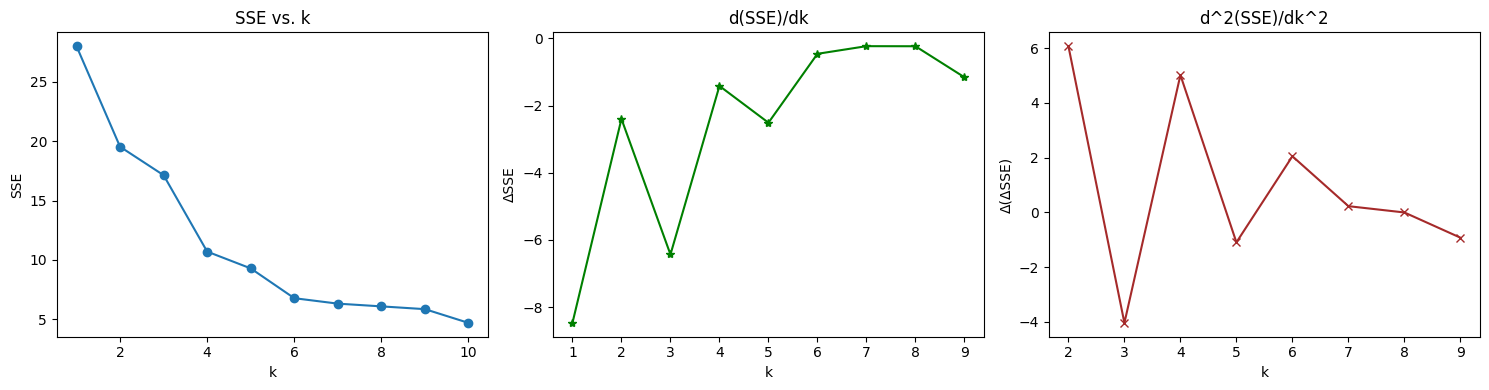

In [ ]:
# -----------------------------------------------------------------------------
#                          One Object Case
# -----------------------------------------------------------------------------
t=1*10

x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T

# -------------------------------
# Elbow Method (cost vs. k)
# -------------------------------
cost_list = []
k_range = range(1, 11)

for k in k_range:
    centr, clust = kmeans_func(X, k, show_plot=0, ini_method=1)
    cost = SSE(X, centr, clust)
    cost_list.append(cost)


# --------------------------------------------
# First Derivative Calculation
# --------------------------------------------
der_list = []
der_range = range(1, len(k_range))

for i in der_range:
    der_list.append(cost_list[i] - cost_list[i-1])


# --------------------------------------------
# Second Derivative Calculation
# --------------------------------------------
der2_list = []
der2_range = range(2, len(k_range))

for i in der2_range:
    der2_list.append(der_list[i-1] - der_list[i-2])


# --------------------------------------------
# Plot: SSE, 1ª e 2ª derivatives
# --------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(k_range, cost_list, marker='o')
axs[0].set_title("SSE vs. k")
axs[0].set_xlabel("k")
axs[0].set_ylabel("SSE")

axs[1].plot(der_range, der_list, marker='*', color='green')
axs[1].set_title("d(SSE)/dk")
axs[1].set_xlabel("k")
axs[1].set_ylabel("ΔSSE")

axs[2].plot(der2_range, der2_list, marker='x', color='brown')
axs[2].set_title("d^2(SSE)/dk^2")
axs[2].set_xlabel("k")
axs[2].set_ylabel("Δ(ΔSSE)")

plt.tight_layout()
plt.show()

(ii) Two Objects Case

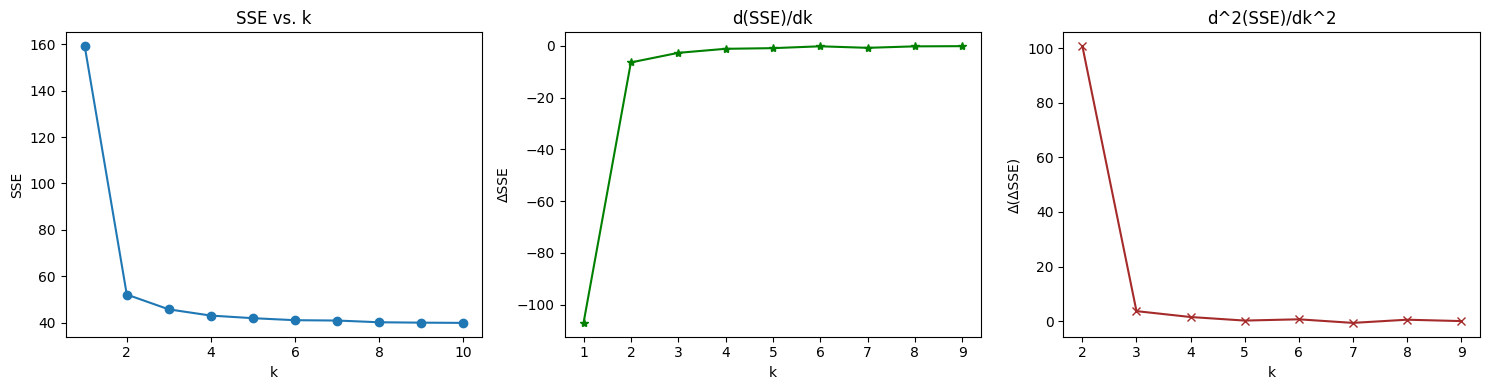

In [ ]:
# -----------------------------------------------------------------------------
#                          Two Object Case
# -----------------------------------------------------------------------------
t=32*10

x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T

# -------------------------------
# Elbow Method (cost vs. k)
# -------------------------------
cost_list = []
k_range = range(1, 11)

for k in k_range:
    centr, clust = kmeans_func(X, k, show_plot=0, ini_method=1)
    cost = SSE(X, centr, clust)
    cost_list.append(cost)


# --------------------------------------------
# First Derivative Calculation
# --------------------------------------------
der_list = []
der_range = range(1, len(k_range))

for i in der_range:
    der_list.append(cost_list[i] - cost_list[i-1])


# --------------------------------------------
# Second Derivative Calculation
# --------------------------------------------
der2_list = []
der2_range = range(2, len(k_range))

for i in der2_range:
    der2_list.append(der_list[i-1] - der_list[i-2])


# --------------------------------------------
# Plot: SSE, 1ª e 2ª derivatives
# --------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(k_range, cost_list, marker='o')
axs[0].set_title("SSE vs. k")
axs[0].set_xlabel("k")
axs[0].set_ylabel("SSE")

axs[1].plot(der_range, der_list, marker='*', color='green')
axs[1].set_title("d(SSE)/dk")
axs[1].set_xlabel("k")
axs[1].set_ylabel("ΔSSE")

axs[2].plot(der2_range, der2_list, marker='x', color='brown')
axs[2].set_title("d^2(SSE)/dk^2")
axs[2].set_xlabel("k")
axs[2].set_ylabel("Δ(ΔSSE)")

plt.tight_layout()
plt.show()

We can observe that it is significantly easier to identify when the LiDAR is measuring the distance to two objects rather than just one. This is because the case of **k = 1** has no past reference point: when **k = 0**, the sum of squared errors (**SSE**) is 0, so there is no observable jump in **SSE** when transitioning from **k = 0** to **k = 1**. In contrast, changes for **k > 1** can be clearly detected through variations in **SSE**.

Given that the main objective is to distinguish measurements involving two objects from those involving only a single object, we can analyze the first or second derivative of the **SSE** curve and define the number of clusters (and hence the number of detected objects) as the value of **k** at which the change in **SSE** falls below a certain threshold.

After performing tests on scenarios with **two** objects, we observed that detecting **k = 2** is relatively straightforward and can be reliably achieved using **high thresholds** (e.g. 50), which also helps prevent **misclassification** due to noise or less significant cluster divisions. Given the ease of identifying **k = 2** and the difficulty of detecting **k = 1**, our strategy is to first check whether **k = 2** is justified. If it is not, we default to **k = 1**, assuming **only one** object is present.

[Frame 0] Detected 1 object
Object at frame 0 classificed as: Square (1.000)
[Torch] Object at frame 0 classificed as: Square (0.970)


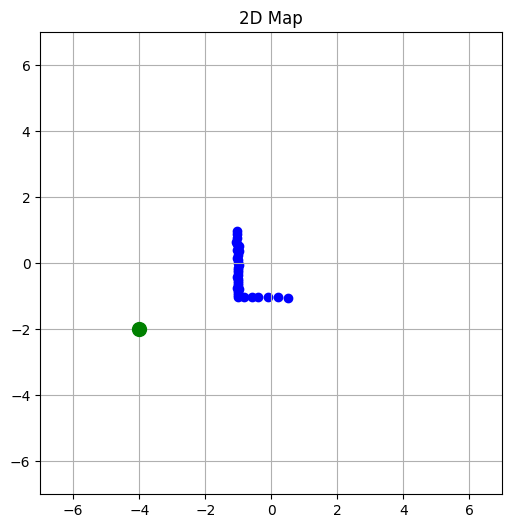

[Frame 10] Detected 1 object
Object at frame 10 classificed as: Square (1.000)
[Torch] Object at frame 10 classificed as: Square (0.975)


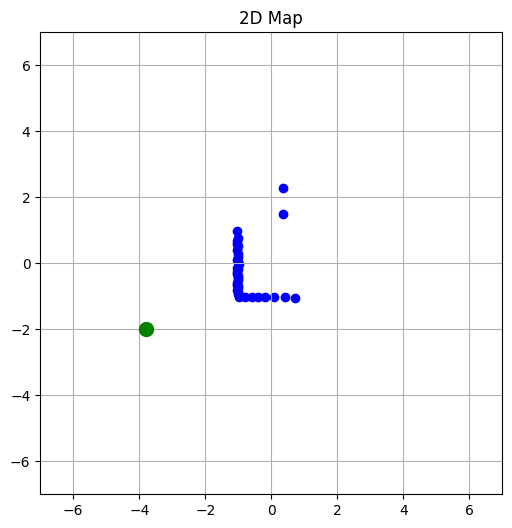

[Frame 20] Detected 1 object


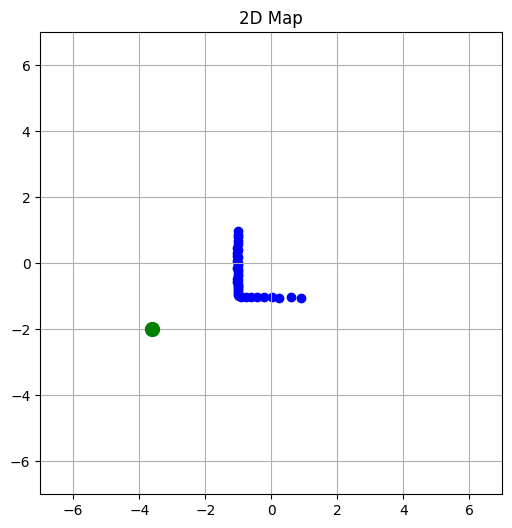

[Frame 30] Detected 1 object
Object at frame 30 classificed as: Square (1.000)
[Torch] Object at frame 30 classificed as: Square (0.977)


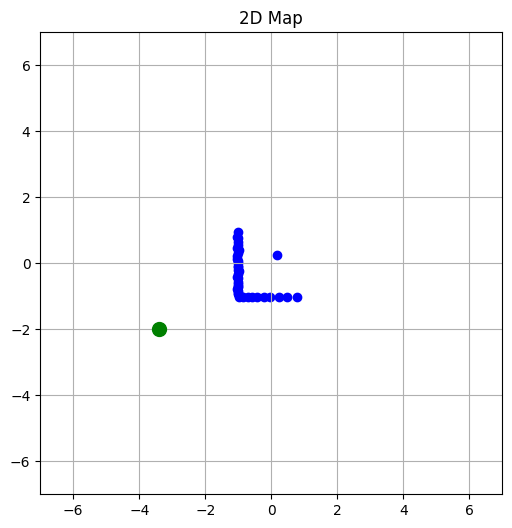

[Frame 40] Detected 1 object
Object at frame 40 classificed as: Square (1.000)
[Torch] Object at frame 40 classificed as: Square (0.977)


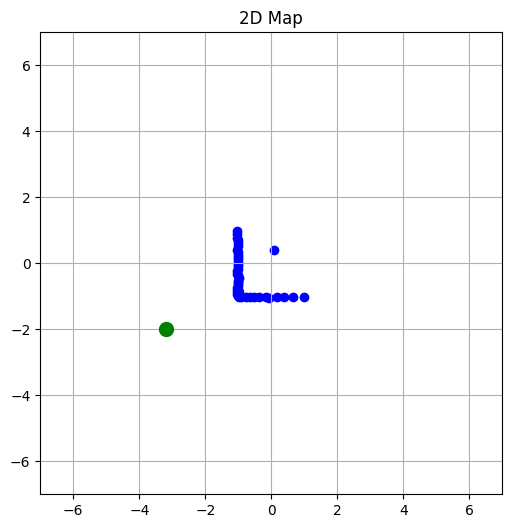

[Frame 50] Detected 1 object
Object at frame 50 classificed as: Square (1.000)
[Torch] Object at frame 50 classificed as: Square (0.978)


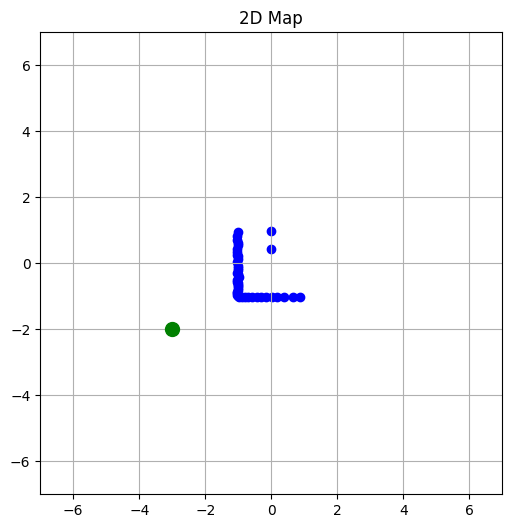

[Frame 60] Detected 1 object
Object at frame 60 classificed as: Square (1.000)
[Torch] Object at frame 60 classificed as: Square (0.978)


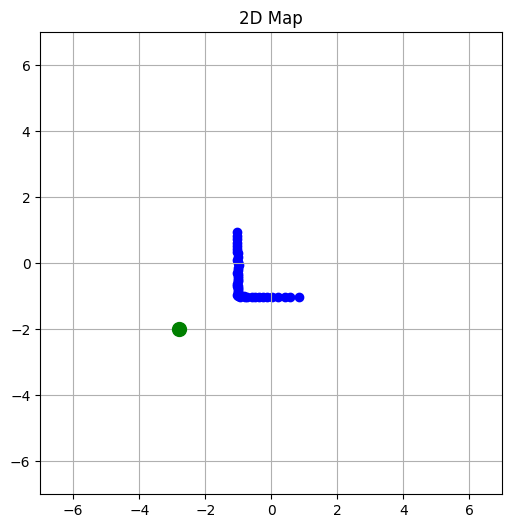

[Frame 70] Detected 1 object
Object at frame 70 classificed as: Square (1.000)
[Torch] Object at frame 70 classificed as: Square (0.979)


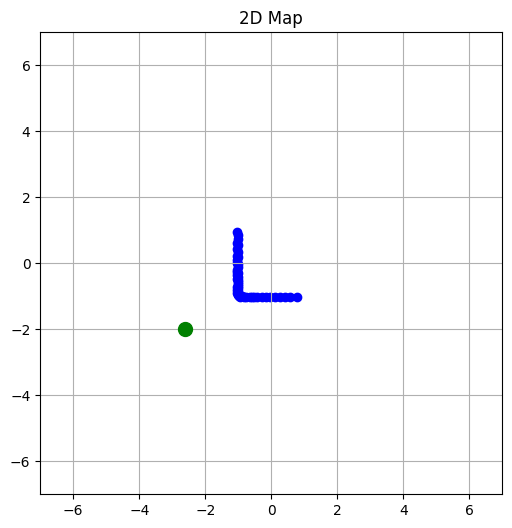

[Frame 80] Detected 1 object
Object at frame 80 classificed as: Square (1.000)
[Torch] Object at frame 80 classificed as: Square (0.979)


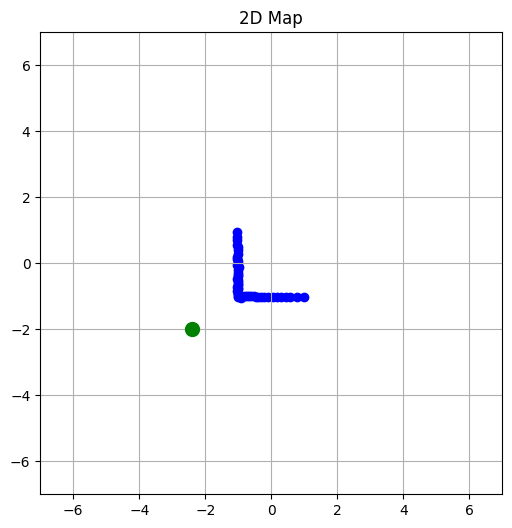

[Frame 90] Detected 1 object
Object at frame 90 classificed as: Square (1.000)
[Torch] Object at frame 90 classificed as: Square (0.979)


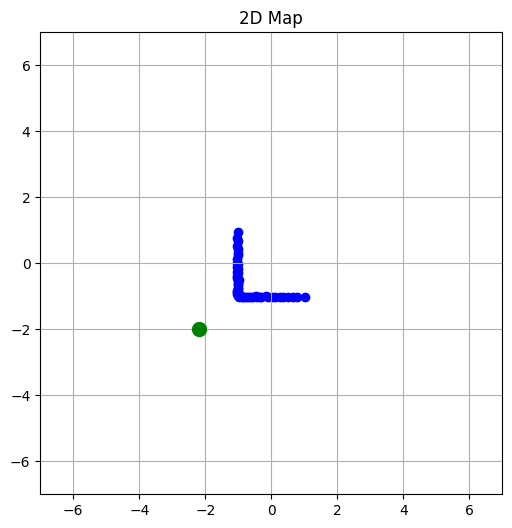

[Frame 100] Detected 1 object
Object at frame 100 classificed as: Square (1.000)
[Torch] Object at frame 100 classificed as: Square (0.979)


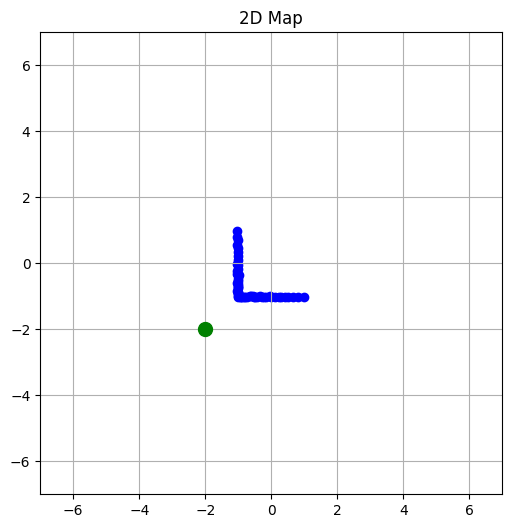

[Frame 110] Detected 1 object
Object at frame 110 classificed as: Square (1.000)
[Torch] Object at frame 110 classificed as: Square (0.976)


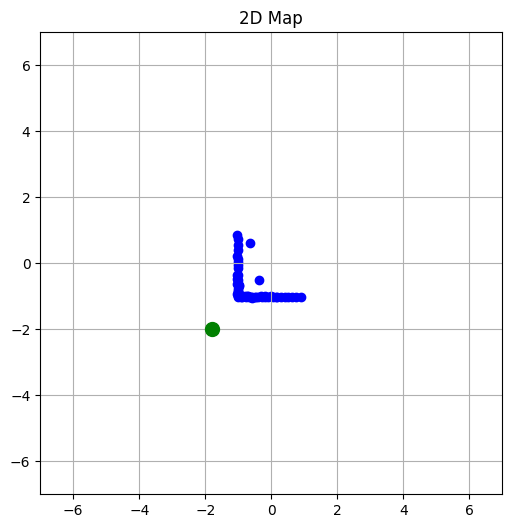

[Frame 120] Detected 1 object
Object at frame 120 classificed as: Square (1.000)
[Torch] Object at frame 120 classificed as: Square (0.974)


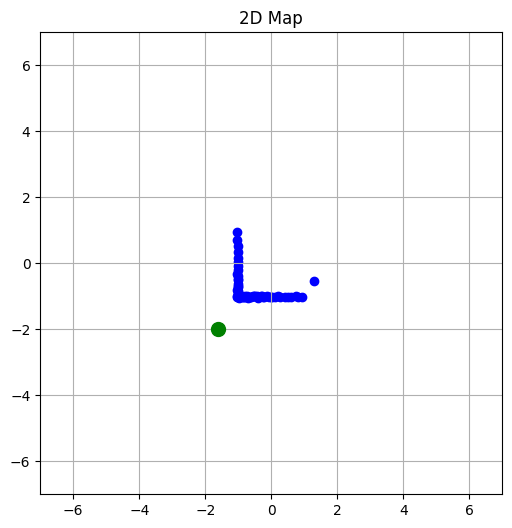

[Frame 130] Detected 1 object
Object at frame 130 classificed as: Square (1.000)
[Torch] Object at frame 130 classificed as: Square (0.951)


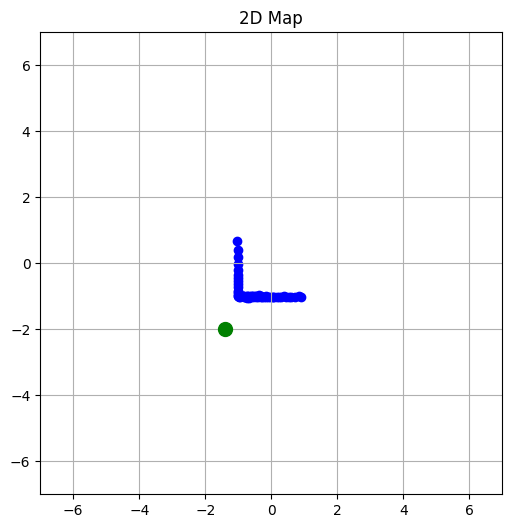

[Frame 140] Detected 1 object
Object at frame 140 classificed as: Square (0.938)
[Torch] Object at frame 140 classificed as: Square (0.591)


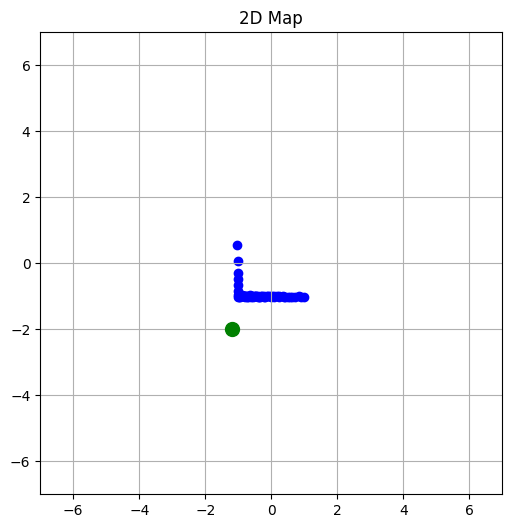

[Frame 150] Detected 1 object
Object at frame 150 classificed as: Square (0.995)
[Torch] Object at frame 150 classificed as: Circle (0.112)


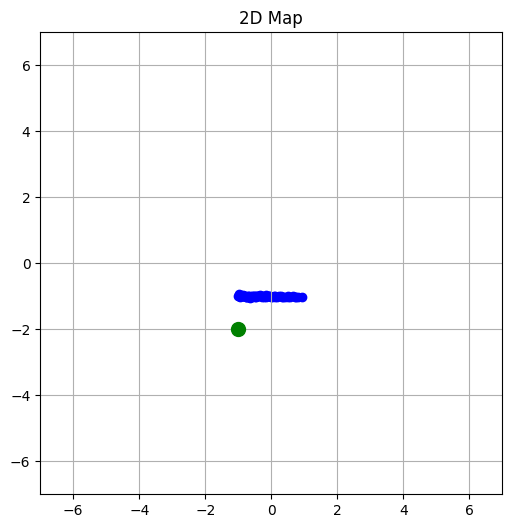

[Frame 160] Detected 1 object
Object at frame 160 classificed as: Square (0.820)
[Torch] Object at frame 160 classificed as: Circle (0.135)


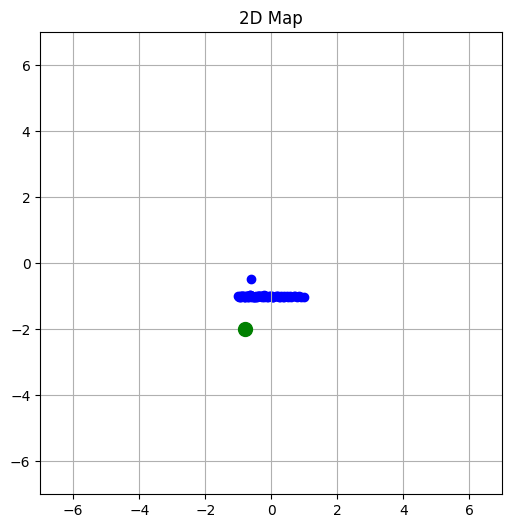

[Frame 170] Detected 2 objects
Object 1 at frame 170 classificed as: Circle (0.000)
[Torch] Object 1 at frame 170 classificed as: Square (0.860)


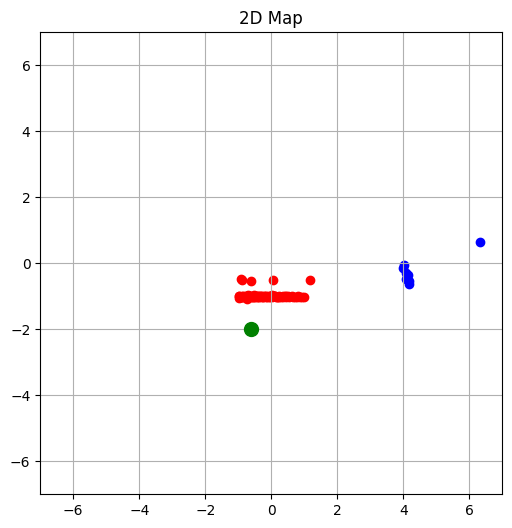

[Frame 180] Detected 2 objects
Object 1 at frame 180 classificed as: Square (0.908)
[Torch] Object 1 at frame 180 classificed as: Square (0.781)
Object 2 at frame 180 classificed as: Square (0.912)
[Torch] Object 2 at frame 180 classificed as: Square (0.649)


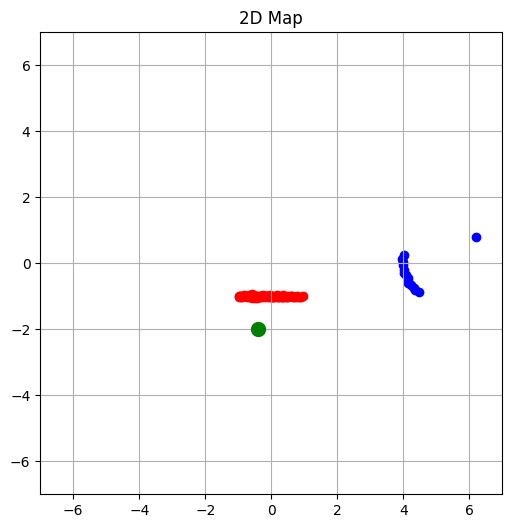

[Frame 190] Detected 2 objects
Object 1 at frame 190 classificed as: Square (0.998)
[Torch] Object 1 at frame 190 classificed as: Square (0.944)
Object 2 at frame 190 classificed as: Circle (0.295)
[Torch] Object 2 at frame 190 classificed as: Circle (0.252)


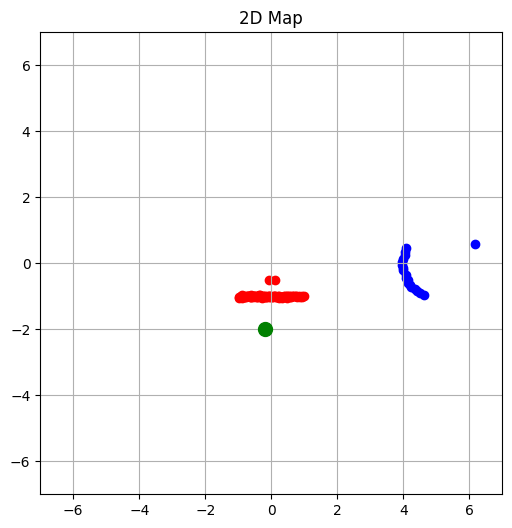

[Frame 200] Detected 2 objects
Object 1 at frame 200 classificed as: Square (0.928)
[Torch] Object 1 at frame 200 classificed as: Square (0.956)
Object 2 at frame 200 classificed as: Circle (0.121)
[Torch] Object 2 at frame 200 classificed as: Circle (0.066)


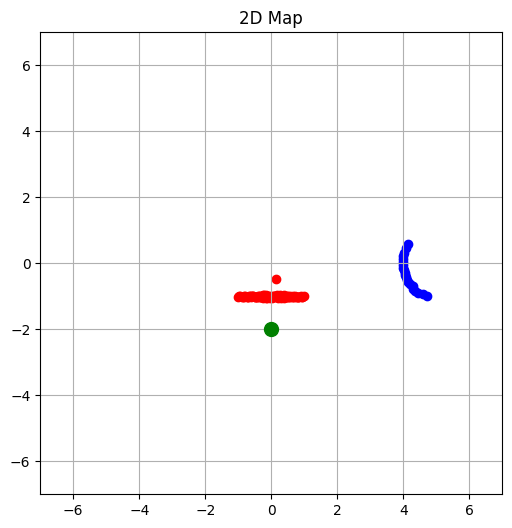

[Frame 210] Detected 2 objects
Object 1 at frame 210 classificed as: Square (0.982)
[Torch] Object 1 at frame 210 classificed as: Square (0.959)
Object 2 at frame 210 classificed as: Circle (0.010)
[Torch] Object 2 at frame 210 classificed as: Circle (0.037)


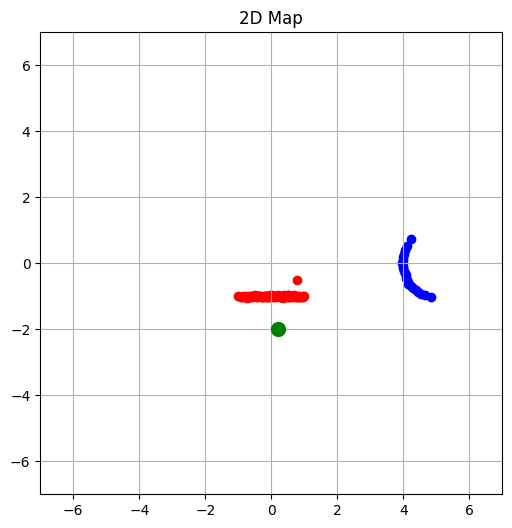

[Frame 220] Detected 2 objects
Object 1 at frame 220 classificed as: Square (0.997)
[Torch] Object 1 at frame 220 classificed as: Square (0.955)
Object 2 at frame 220 classificed as: Circle (0.000)
[Torch] Object 2 at frame 220 classificed as: Circle (0.039)


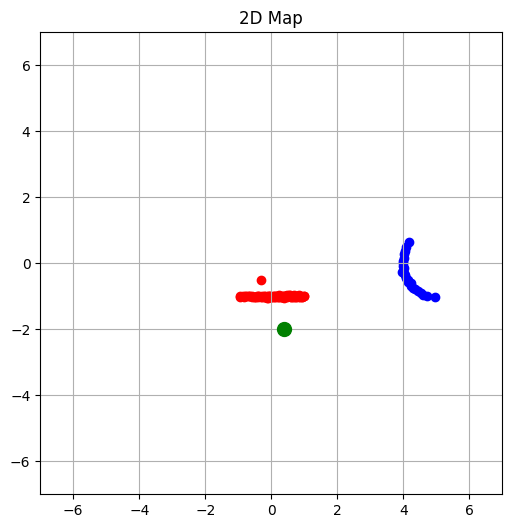

[Frame 230] Detected 2 objects
Object 1 at frame 230 classificed as: Square (0.997)
[Torch] Object 1 at frame 230 classificed as: Square (0.961)
Object 2 at frame 230 classificed as: Circle (0.166)
[Torch] Object 2 at frame 230 classificed as: Circle (0.056)


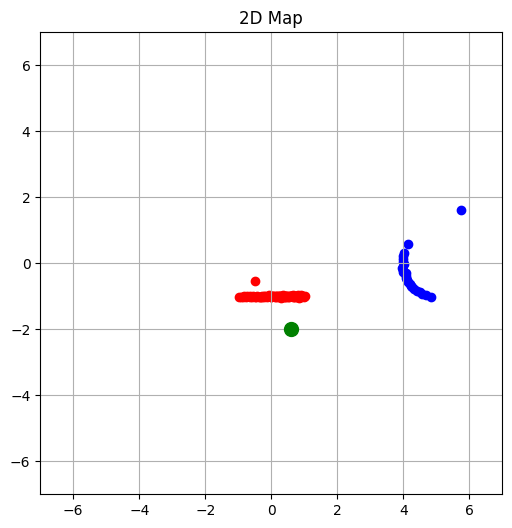

[Frame 240] Detected 2 objects
Object 1 at frame 240 classificed as: Square (0.999)
[Torch] Object 1 at frame 240 classificed as: Square (0.958)
Object 2 at frame 240 classificed as: Square (0.575)
[Torch] Object 2 at frame 240 classificed as: Circle (0.125)


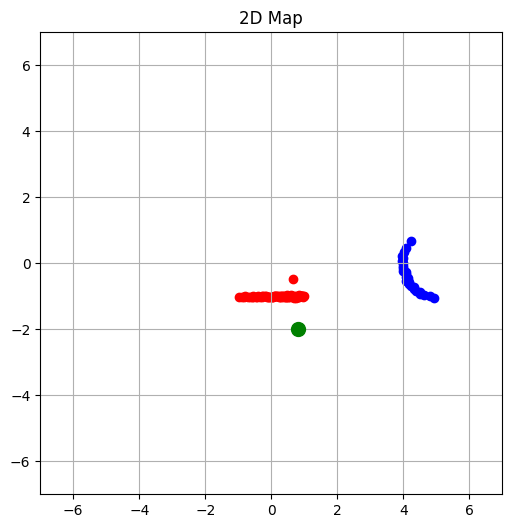

[Frame 250] Detected 2 objects
Object 1 at frame 250 classificed as: Square (1.000)
[Torch] Object 1 at frame 250 classificed as: Square (0.953)
Object 2 at frame 250 classificed as: Circle (0.006)
[Torch] Object 2 at frame 250 classificed as: Circle (0.073)


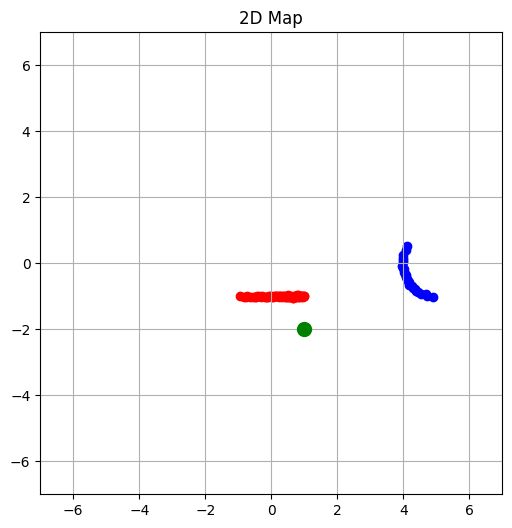

[Frame 260] Detected 2 objects
Object 1 at frame 260 classificed as: Square (1.000)
[Torch] Object 1 at frame 260 classificed as: Square (0.978)
Object 2 at frame 260 classificed as: Square (1.000)
[Torch] Object 2 at frame 260 classificed as: Square (0.963)


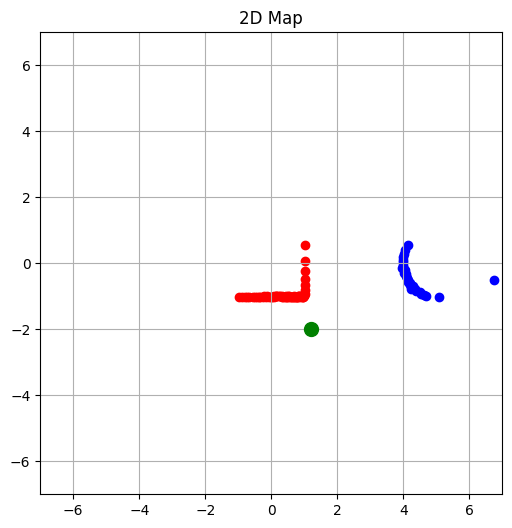

[Frame 270] Detected 2 objects
Object 1 at frame 270 classificed as: Square (1.000)
[Torch] Object 1 at frame 270 classificed as: Square (0.978)
Object 2 at frame 270 classificed as: Circle (0.001)
[Torch] Object 2 at frame 270 classificed as: Circle (0.069)


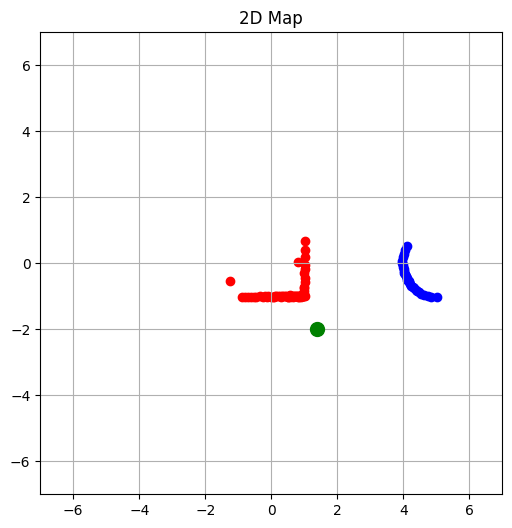

[Frame 280] Detected 2 objects
Object 1 at frame 280 classificed as: Square (1.000)
[Torch] Object 1 at frame 280 classificed as: Square (0.979)
Object 2 at frame 280 classificed as: Circle (0.060)
[Torch] Object 2 at frame 280 classificed as: Circle (0.105)


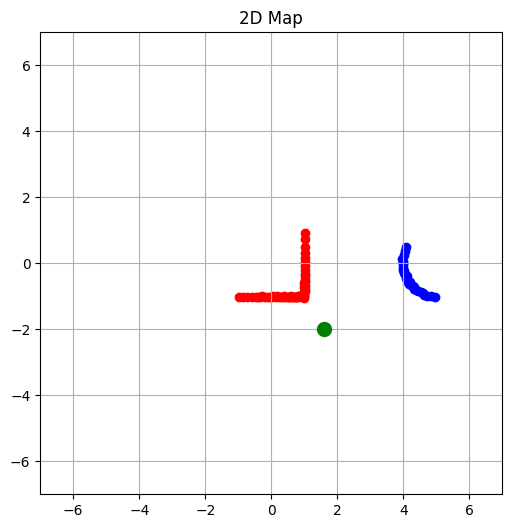

[Frame 290] Detected 2 objects
Object 1 at frame 290 classificed as: Square (1.000)
[Torch] Object 1 at frame 290 classificed as: Square (0.980)
Object 2 at frame 290 classificed as: Circle (0.043)
[Torch] Object 2 at frame 290 classificed as: Circle (0.097)


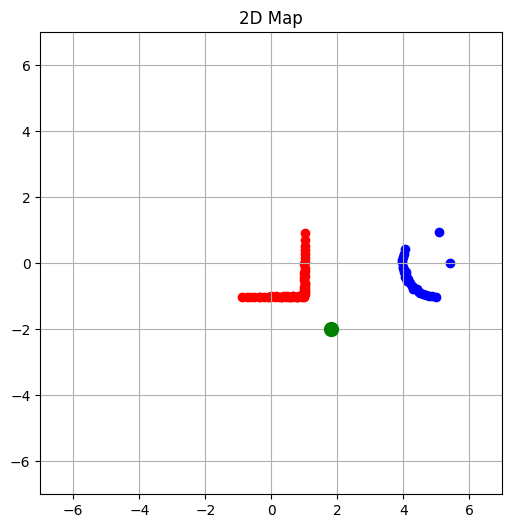

[Frame 300] Detected 2 objects
Object 1 at frame 300 classificed as: Square (1.000)
[Torch] Object 1 at frame 300 classificed as: Square (0.979)
Object 2 at frame 300 classificed as: Circle (0.039)
[Torch] Object 2 at frame 300 classificed as: Circle (0.107)


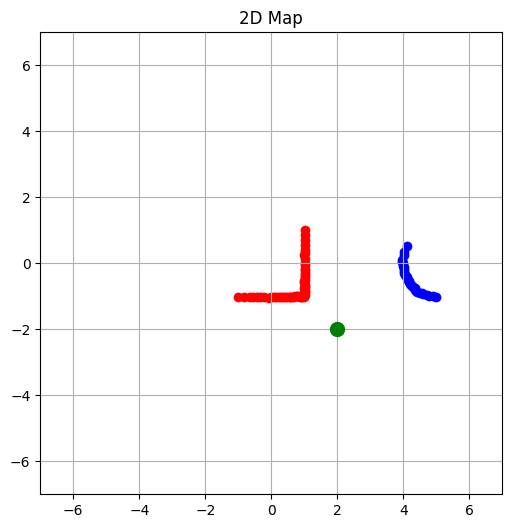

[Frame 310] Detected 2 objects
Object 1 at frame 310 classificed as: Square (1.000)
[Torch] Object 1 at frame 310 classificed as: Square (0.976)
Object 2 at frame 310 classificed as: Circle (0.027)
[Torch] Object 2 at frame 310 classificed as: Circle (0.183)


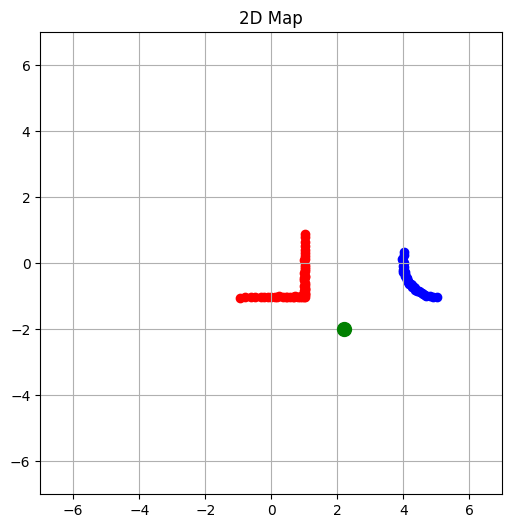

[Frame 320] Detected 2 objects
Object 1 at frame 320 classificed as: Square (1.000)
[Torch] Object 1 at frame 320 classificed as: Square (0.966)
Object 2 at frame 320 classificed as: Circle (0.001)
[Torch] Object 2 at frame 320 classificed as: Circle (0.074)


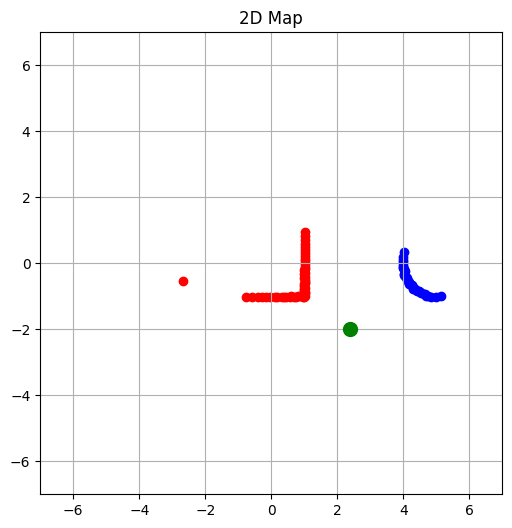

[Frame 330] Detected 2 objects
Object 1 at frame 330 classificed as: Square (1.000)
[Torch] Object 1 at frame 330 classificed as: Square (0.941)
Object 2 at frame 330 classificed as: Square (0.696)
[Torch] Object 2 at frame 330 classificed as: Circle (0.085)


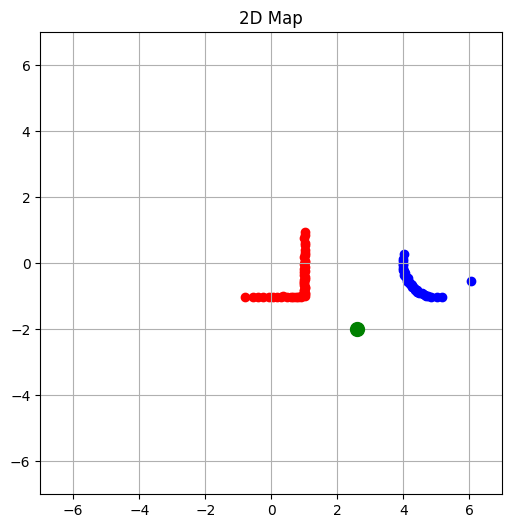

[Frame 340] Detected 2 objects
Object 1 at frame 340 classificed as: Square (1.000)
[Torch] Object 1 at frame 340 classificed as: Square (0.863)
Object 2 at frame 340 classificed as: Square (0.564)
[Torch] Object 2 at frame 340 classificed as: Circle (0.429)


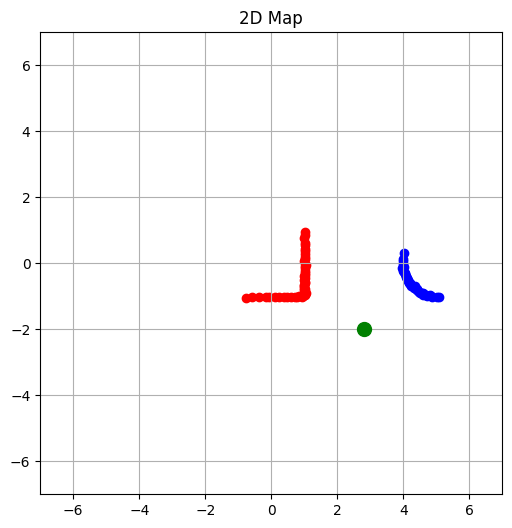

[Frame 350] Detected 2 objects
Object 1 at frame 350 classificed as: Square (0.999)
[Torch] Object 1 at frame 350 classificed as: Square (0.519)
Object 2 at frame 350 classificed as: Circle (0.005)
[Torch] Object 2 at frame 350 classificed as: Circle (0.106)


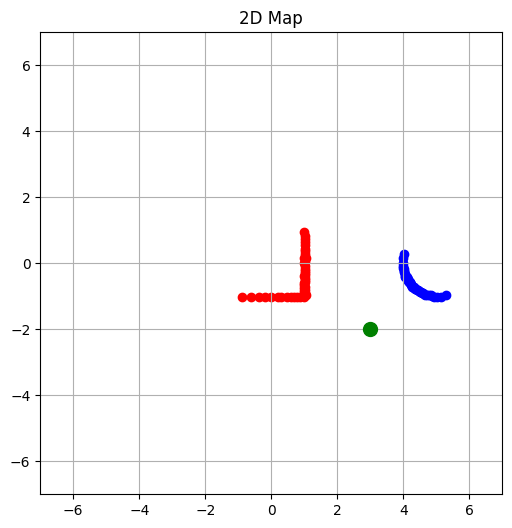

[Frame 360] Detected 2 objects
Object 1 at frame 360 classificed as: Square (0.999)
[Torch] Object 1 at frame 360 classificed as: Circle (0.239)
Object 2 at frame 360 classificed as: Square (1.000)
[Torch] Object 2 at frame 360 classificed as: Circle (0.278)


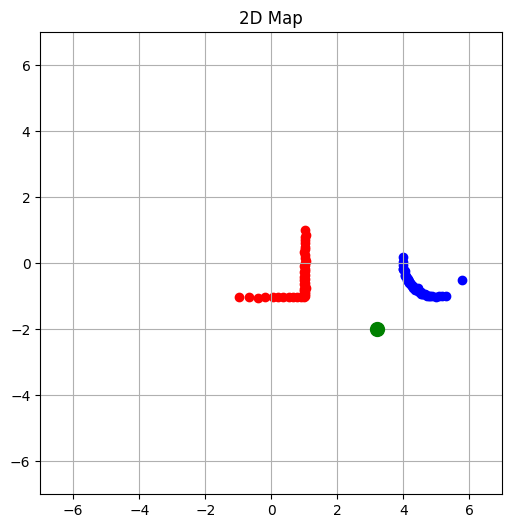

[Frame 370] Detected 2 objects
Object 1 at frame 370 classificed as: Square (0.997)
[Torch] Object 1 at frame 370 classificed as: Circle (0.207)
Object 2 at frame 370 classificed as: Circle (0.001)
[Torch] Object 2 at frame 370 classificed as: Circle (0.076)


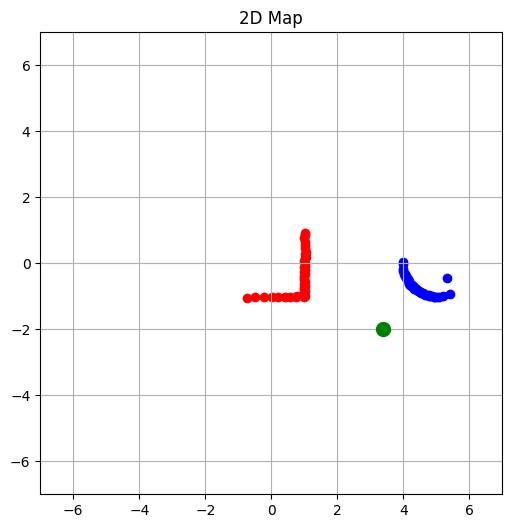

[Frame 380] Detected 2 objects
Object 1 at frame 380 classificed as: Square (1.000)
[Torch] Object 1 at frame 380 classificed as: Square (0.964)
Object 2 at frame 380 classificed as: Circle (0.014)
[Torch] Object 2 at frame 380 classificed as: Circle (0.070)


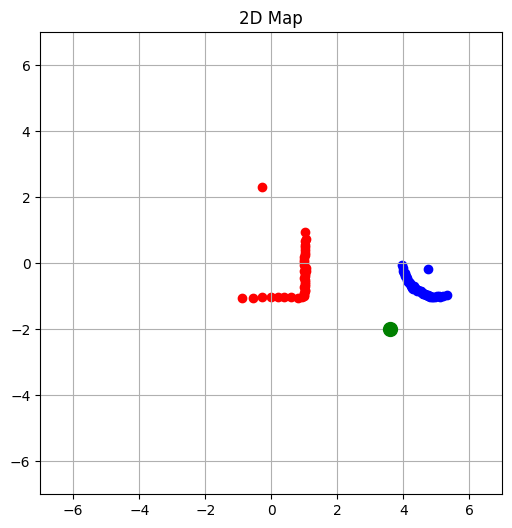

[Frame 390] Detected 2 objects
Object 1 at frame 390 classificed as: Square (0.981)
[Torch] Object 1 at frame 390 classificed as: Circle (0.093)
Object 2 at frame 390 classificed as: Circle (0.016)
[Torch] Object 2 at frame 390 classificed as: Circle (0.252)


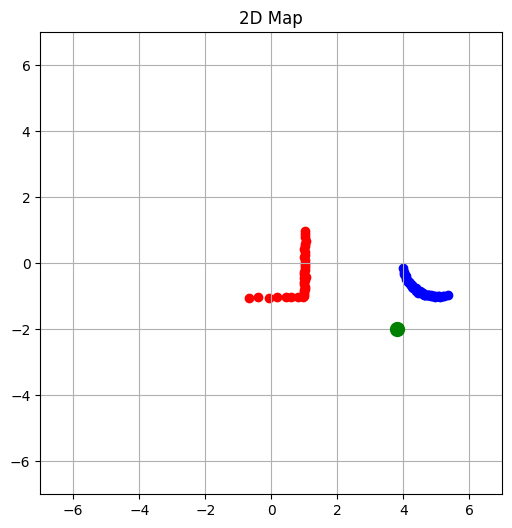

[Frame 400] Detected 2 objects
Object 1 at frame 400 classificed as: Square (0.995)
[Torch] Object 1 at frame 400 classificed as: Circle (0.095)
Object 2 at frame 400 classificed as: Circle (0.003)
[Torch] Object 2 at frame 400 classificed as: Circle (0.071)


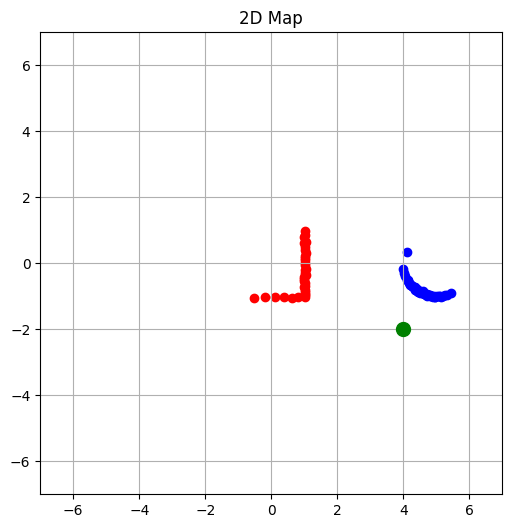

[Frame 410] Detected 2 objects
Object 1 at frame 410 classificed as: Square (1.000)
[Torch] Object 1 at frame 410 classificed as: Circle (0.482)
Object 2 at frame 410 classificed as: Circle (0.017)
[Torch] Object 2 at frame 410 classificed as: Circle (0.328)


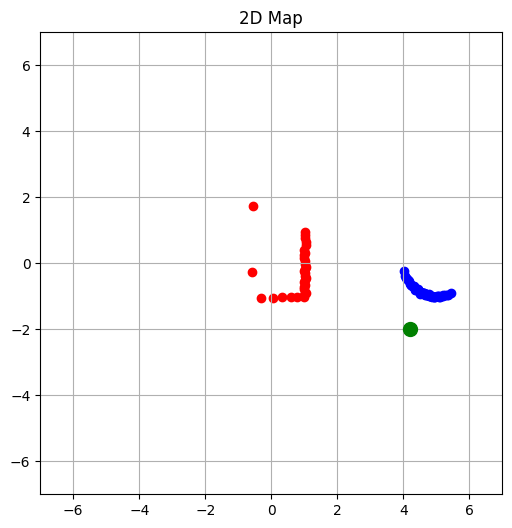

[Frame 420] Detected 2 objects
Object 1 at frame 420 classificed as: Square (0.999)
[Torch] Object 1 at frame 420 classificed as: Circle (0.090)
Object 2 at frame 420 classificed as: Circle (0.076)
[Torch] Object 2 at frame 420 classificed as: Circle (0.159)


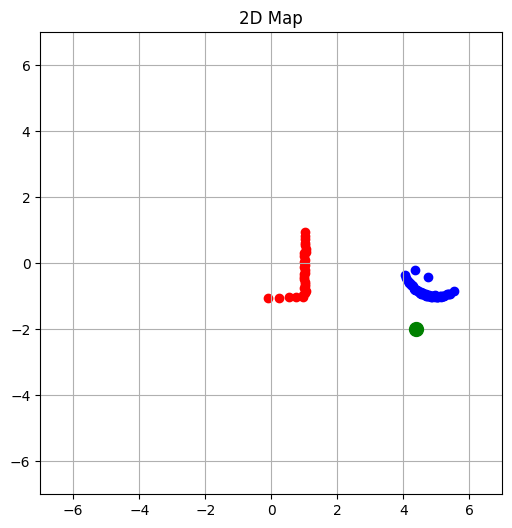

[Frame 430] Detected 2 objects
Object 1 at frame 430 classificed as: Square (0.989)
[Torch] Object 1 at frame 430 classificed as: Circle (0.149)
Object 2 at frame 430 classificed as: Circle (0.004)
[Torch] Object 2 at frame 430 classificed as: Circle (0.086)


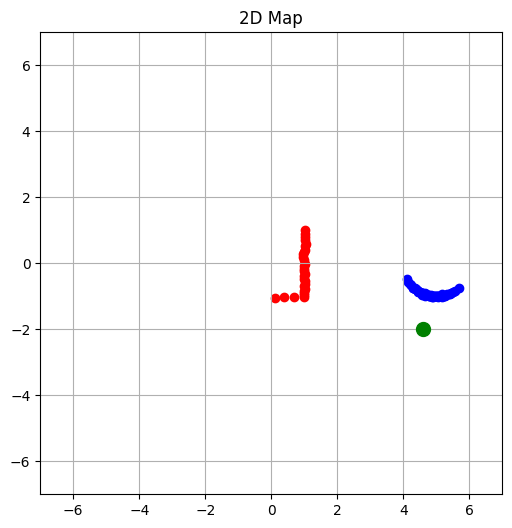

[Frame 440] Detected 2 objects
Object 1 at frame 440 classificed as: Square (0.999)
[Torch] Object 1 at frame 440 classificed as: Circle (0.074)
Object 2 at frame 440 classificed as: Square (1.000)
[Torch] Object 2 at frame 440 classificed as: Circle (0.322)


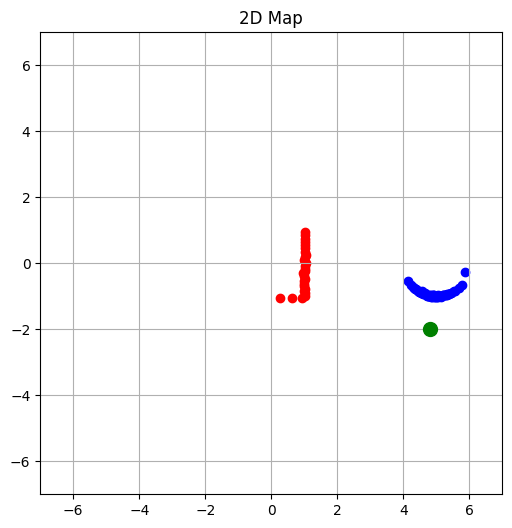

[Frame 450] Detected 2 objects
Object 1 at frame 450 classificed as: Square (0.997)
[Torch] Object 1 at frame 450 classificed as: Circle (0.056)
Object 2 at frame 450 classificed as: Circle (0.043)
[Torch] Object 2 at frame 450 classificed as: Circle (0.072)


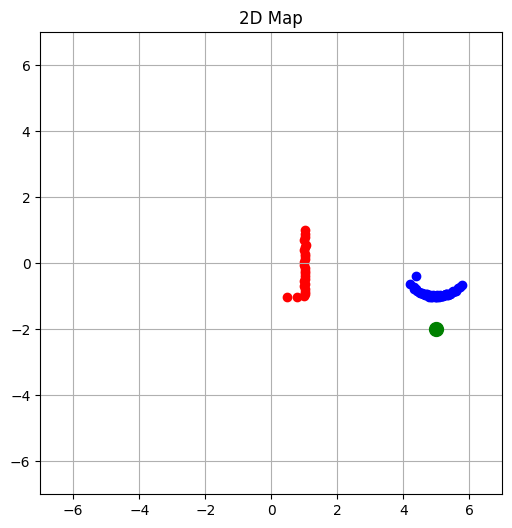

[Frame 460] Detected 2 objects
Object 1 at frame 460 classificed as: Square (0.999)
[Torch] Object 1 at frame 460 classificed as: Circle (0.071)
Object 2 at frame 460 classificed as: Circle (0.000)
[Torch] Object 2 at frame 460 classificed as: Square (0.916)


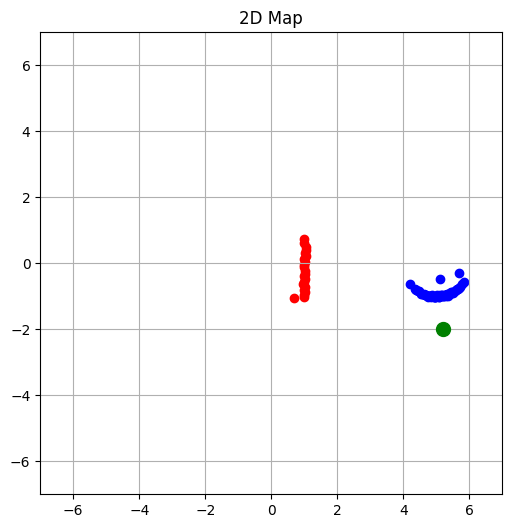

[Frame 470] Detected 2 objects
Object 1 at frame 470 classificed as: Square (1.000)
[Torch] Object 1 at frame 470 classificed as: Circle (0.315)
Object 2 at frame 470 classificed as: Circle (0.001)
[Torch] Object 2 at frame 470 classificed as: Circle (0.060)


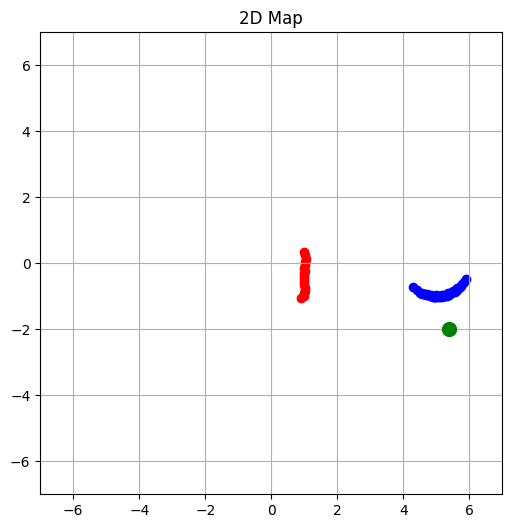

[Frame 480] Detected 2 objects
Object 1 at frame 480 classificed as: Square (0.999)
[Torch] Object 1 at frame 480 classificed as: Square (0.674)
Object 2 at frame 480 classificed as: Circle (0.016)
[Torch] Object 2 at frame 480 classificed as: Circle (0.073)


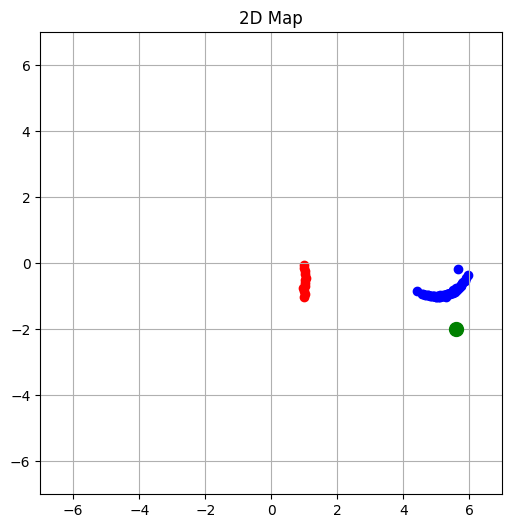

[Frame 490] Detected 2 objects
Object 2 at frame 490 classificed as: Circle (0.001)
[Torch] Object 2 at frame 490 classificed as: Circle (0.064)


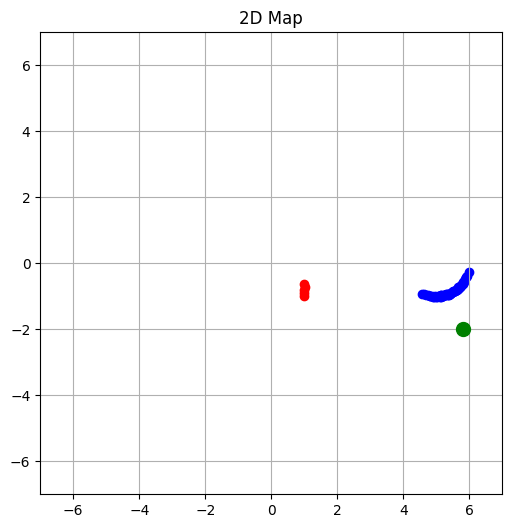

[Frame 500] Detected 1 object
Object at frame 500 classificed as: Circle (0.043)
[Torch] Object at frame 500 classificed as: Circle (0.095)


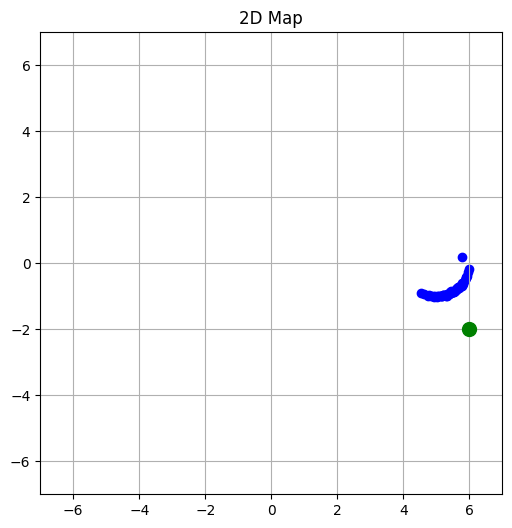

[Frame 510] Detected 1 object
Object at frame 510 classificed as: Square (1.000)
[Torch] Object at frame 510 classificed as: Square (0.945)


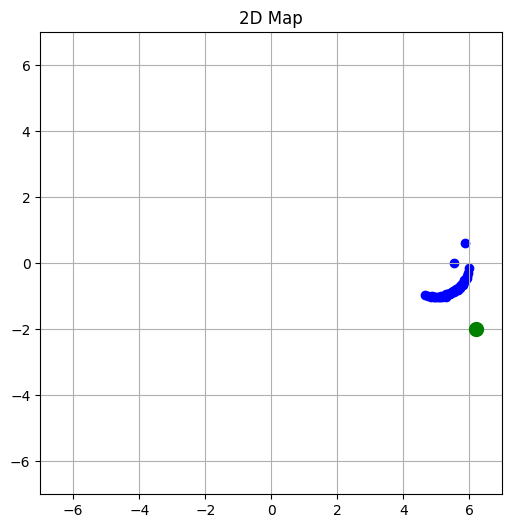

[Frame 520] Detected 1 object
Object at frame 520 classificed as: Circle (0.053)
[Torch] Object at frame 520 classificed as: Circle (0.075)


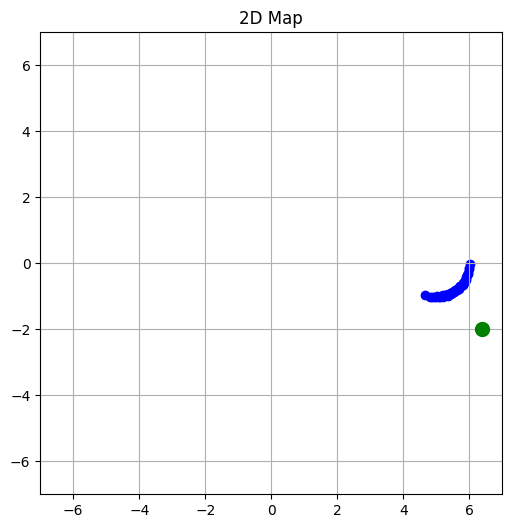

[Frame 530] Detected 1 object
Object at frame 530 classificed as: Circle (0.019)
[Torch] Object at frame 530 classificed as: Circle (0.154)


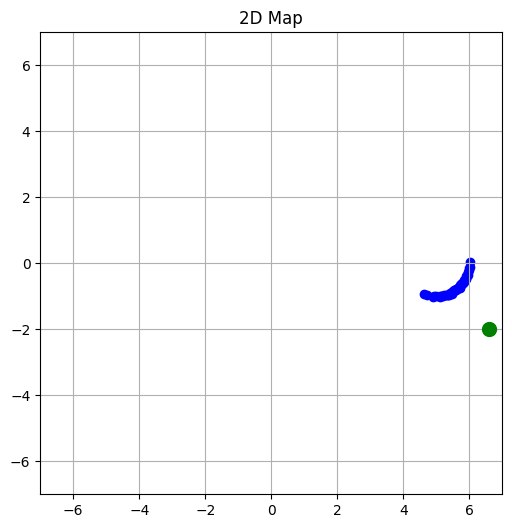

[Frame 540] Detected 1 object
Object at frame 540 classificed as: Circle (0.032)
[Torch] Object at frame 540 classificed as: Circle (0.123)


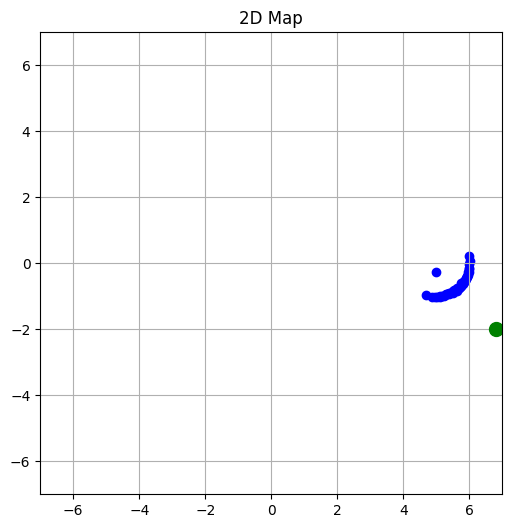

[Frame 550] Detected 1 object
Object at frame 550 classificed as: Circle (0.062)
[Torch] Object at frame 550 classificed as: Circle (0.316)


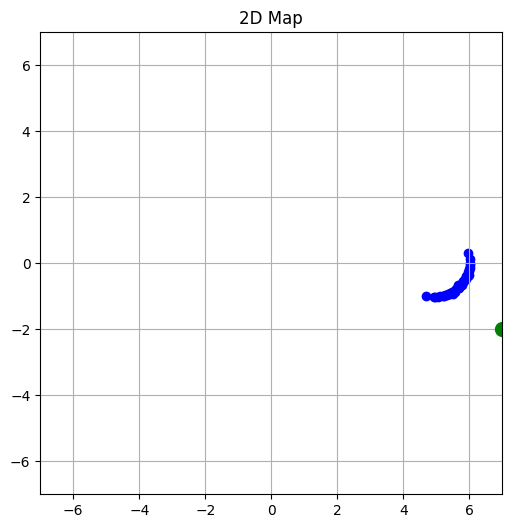

[Frame 560] Detected 1 object
Object at frame 560 classificed as: Circle (0.000)
[Torch] Object at frame 560 classificed as: Circle (0.063)


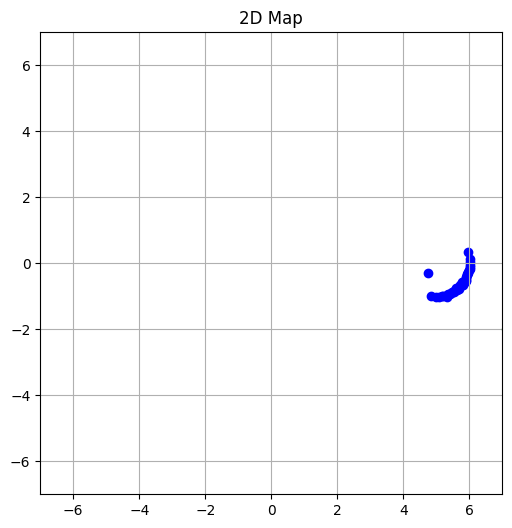

[Frame 570] Detected 1 object
Object at frame 570 classificed as: Square (0.554)
[Torch] Object at frame 570 classificed as: Circle (0.317)


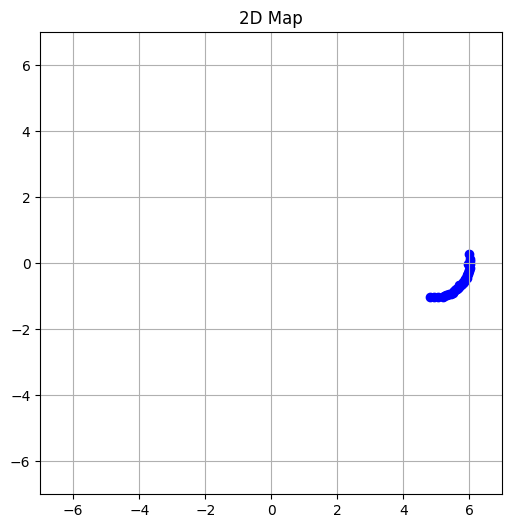

[Frame 580] Detected 1 object
Object at frame 580 classificed as: Square (0.568)
[Torch] Object at frame 580 classificed as: Circle (0.399)


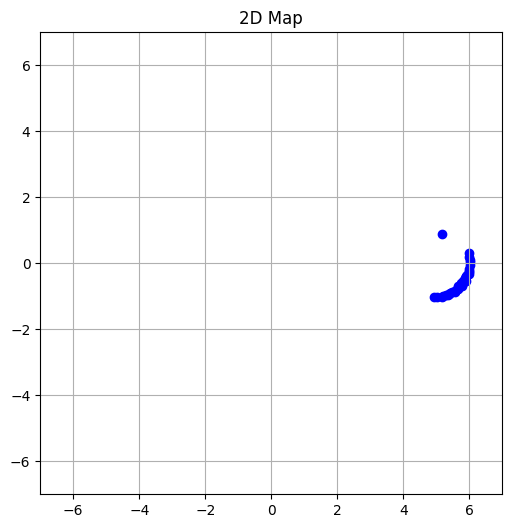

[Frame 590] Detected 1 object
Object at frame 590 classificed as: Circle (0.049)
[Torch] Object at frame 590 classificed as: Circle (0.128)


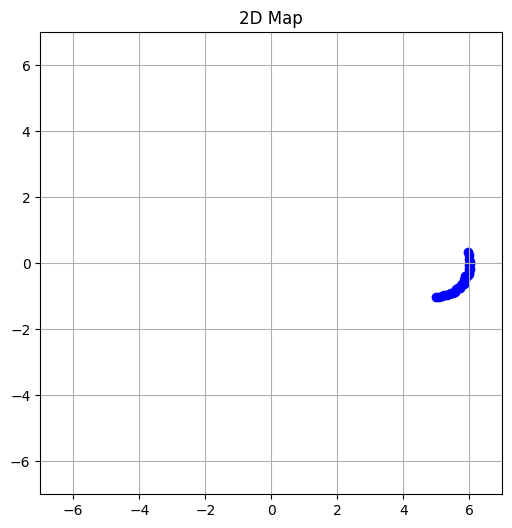

In [ ]:
# To complete - Parcially Done -
# NOTA: Correr primeiro a alíena 2.3
Threshold = 20  # to decide if k=1 or k=2,

Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

pX, pY = [], []
angles = []

# Building the data set for ANN testing using k-means to split objects
test_set_X = np.array([])
input_samples = []
nn_idx = np.array([])

print_rate = 10
squares, circles = 0, 0
clf_thr = 0.5

for t in range(len(Lidar_range)):
  x_o, y_o = [], []
  nn_idx = np.array([])
  nn_10st_idx = np.array([])
  for i in range(len(Lidar_range[t])):
      if Lidar_range[t][i] > 0:
          nn_idx = np.append(nn_idx, i)
          x_o.append(px[t] + Lidar_range[t][i] * np.cos(angle[i] / 180 * np.pi))
          y_o.append(py[t] + Lidar_range[t][i] * np.sin(angle[i] / 180 * np.pi))
  X = np.array([x_o, y_o]).T
  cost_list = []
  k_range = range(1, 3)
  for k in k_range:
    centr, clust = kmeans_func(X, k, show_plot=0, ini_method=1)
    # Calculate SSE
    cost = SSE(X, centr, clust)
    cost_list.append(cost)
  #Let's now decide if this snapshot has 1 or 2 obstacles
  if (cost_list[0] - cost_list[1]) > Threshold:
    #2 objects
    if t % print_rate == 0:
        print(f"[Frame {t}] Detected 2 objects")
    X_feature1, X_feature2 = np.zeros([N_INPUTS]), np.zeros([N_INPUTS])
    j1, j2 = 0, 0

    # Obtain cluster's centroid to sort
    for k in k_range:
      if k == 2:
          centr, clust = kmeans_func(X, k, show_plot=0, ini_method=1)
          break
    if centr[0][0] < centr[1][0]:
        cluster_left = 0
        cluster_right = 1
    else:
        cluster_left = 1
        cluster_right = 0

    x_o_plot_cluster0, y_o_plot_cluster0 = [], []
    x_o_plot_cluster1, y_o_plot_cluster1 = [], []
    x_o_cluster0, y_o_cluster0 = [], []
    x_o_cluster1, y_o_cluster1 = [], []

    for i in range(len(x_o)):
      if clust[i] == cluster_left:
          x_o_plot_cluster0.append(x_o[i])
          y_o_plot_cluster0.append(y_o[i])
      elif clust[i] == cluster_right:
          x_o_plot_cluster1.append(x_o[i])
          y_o_plot_cluster1.append(y_o[i])

    # Feature extraction and Classification for 1st Object ---------------
    nn_10st_idx = np.array([])
    ann_inputs = np.array([])

    for i in range(len(x_o)):
      if j1 < N_INPUTS:
        if clust[i] == cluster_left:
          nn_10st_idx = np.append(nn_10st_idx, nn_idx[i])
          X_feature1[j1]=np.sqrt((x_o[i]-px[t])**2 + (y_o[i]-py[t])**2)
          x_o_cluster0.append(x_o[i])
          y_o_cluster0.append(y_o[i])
          j1 = j1 + 1

    if j1 == 10:
      ann_inputs = Lidar_range[t][nn_10st_idx.astype(int)]
      ann_inputs = np.array(ann_inputs).reshape(-1)
      classification_ann = ann_model.feedforward(ann_inputs, False)
      if classification_ann - clf_thr <= 0:
        circles += 1
        if t % print_rate == 0:
          print(f"Object 1 at frame {t} classificed as: Circle ({classification_ann:.3f})")
      elif classification_ann - clf_thr > 0:
        squares +=1
        if t % print_rate == 0:
          print(f"Object 1 at frame {t} classificed as: Square ({classification_ann:.3f})")

      # PyTorch NN Classification
      pyT_inputs = torch.tensor(ann_inputs, dtype=torch.float32)
      pyT_inputs = pyT_inputs.unsqueeze(0)
      pyT_inputs = pyT_inputs.to(device)
      pyT_model.eval()
      with torch.no_grad():
        pyT_outputs = pyT_model(pyT_inputs)
        pyT_classification = torch.sigmoid(pyT_outputs).item()
      if pyT_classification - clf_thr <= 0:
        circles += 1
        if t % print_rate == 0:
          print(f"[Torch] Object 1 at frame {t} classificed as: Circle ({pyT_classification:.3f})")
      elif pyT_classification - clf_thr > 0:
        squares +=1
        if t % print_rate == 0:
          print(f"[Torch] Object 1 at frame {t} classificed as: Square ({pyT_classification:.3f})")

    # Feature extraction and Classification for 2nd Object ---------------
    nn_10st_idx = np.array([])
    ann_inputs = np.array([])

    for i in range(len(x_o)):
      if j2 < N_INPUTS:
        if clust[i] == cluster_right:
          nn_10st_idx = np.append(nn_10st_idx, nn_idx[i])
          X_feature2[j2]=np.sqrt((x_o[i]-px[t])**2 + (y_o[i]-py[t])**2)
          x_o_cluster1.append(x_o[i])
          y_o_cluster1.append(y_o[i])
          j2 = j2 + 1

    if j2 == 10:
      ann_inputs = Lidar_range[t][nn_10st_idx.astype(int)]
      ann_inputs = np.array(ann_inputs).reshape(-1)
      classification_ann = ann_model.feedforward(ann_inputs)
      if classification_ann - clf_thr <= 0:
        circles += 1
        if t % print_rate == 0:
          print(f"Object 2 at frame {t} classificed as: Circle ({classification_ann:.3f})")
      elif classification_ann - clf_thr > 0:
        squares +=1
        if t % print_rate == 0:
          print(f"Object 2 at frame {t} classificed as: Square ({classification_ann:.3f})")

      # PyTorch NN Classification
      pyT_inputs = torch.tensor(ann_inputs, dtype=torch.float32)
      pyT_inputs = pyT_inputs.unsqueeze(0)
      pyT_inputs = pyT_inputs.to(device)
      pyT_model.eval()
      with torch.no_grad():
        pyT_outputs = pyT_model(pyT_inputs)
        pyT_classification = torch.sigmoid(pyT_outputs).item()
      if pyT_classification - clf_thr <= 0:
        circles += 1
        if t % print_rate == 0:
          print(f"[Torch] Object 2 at frame {t} classificed as: Circle ({pyT_classification:.3f})")
      elif pyT_classification - clf_thr > 0:
        squares +=1
        if t % print_rate == 0:
          print(f"[Torch] Object 2 at frame {t} classificed as: Square ({pyT_classification:.3f})")


    # Add feature (distance) to test set ---------------------------------

    if len(test_set_X) == 0:
      test_set_X = np.array([X_feature1, X_feature2])
    else:
      test_set_X = np.concatenate((test_set_X, np.array([X_feature1, X_feature2])))

  else: #only one object
    if t % print_rate == 0:
      print(f"[Frame {t}] Detected 1 object")
    X_feature1 = np.zeros([N_INPUTS])
    j1 = 0

    # Feature Extraction and Classification for Single object ----------------
    nn_10st_idx = np.array([])
    ann_inputs = np.array([])

    for i in range(len(x_o)):
      if j1 < N_INPUTS:
        if clust[i] == 0:
          nn_10st_idx = np.append(nn_10st_idx, nn_idx[i])
          X_feature1[j1]=np.sqrt((x_o[i]-px[t])**2 + (y_o[i]-py[t])**2)
          j1 = j1 +1

    if j1 == 10:
      ann_inputs = Lidar_range[t][nn_10st_idx.astype(int)]
      ann_inputs = np.array(ann_inputs).reshape(-1)

      classification_ann = ann_model.feedforward(ann_inputs)
      if classification_ann - clf_thr <= 0:
        circles += 1
        if t % print_rate == 0:
          print(f"Object at frame {t} classificed as: Circle ({classification_ann:.3f})")
      elif classification_ann - clf_thr > 0:
        squares +=1
        if t % print_rate == 0:
          print(f"Object at frame {t} classificed as: Square ({classification_ann:.3f})")

      # PyTorch NN Classification
      pyT_inputs = torch.tensor(ann_inputs, dtype=torch.float32)
      pyT_inputs = pyT_inputs.unsqueeze(0)
      pyT_inputs = pyT_inputs.to(device)
      pyT_model.eval()
      with torch.no_grad():
        pyT_outputs = pyT_model(pyT_inputs)
        pyT_classification = torch.sigmoid(pyT_outputs).item()
      if pyT_classification - clf_thr <= 0:
        circles += 1
        if t % print_rate == 0:
          print(f"[Torch] Object at frame {t} classificed as: Circle ({pyT_classification:.3f})")
      elif pyT_classification - clf_thr > 0:
        squares +=1
        if t % print_rate == 0:
          print(f"[Torch] Object at frame {t} classificed as: Square ({pyT_classification:.3f})")


    if len(test_set_X) == 0:
      test_set_X = np.array([X_feature1])
    else:
      test_set_X = np.concatenate((test_set_X, np.array([X_feature1])))
    pX.append(px[t])
    pY.append(py[t])
  if t % print_rate == 0:

    # ===================================
    #               Ploting
    # ===================================
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal', adjustable='box')
    xdim, ydim = 6, 6
    plt.xlim(-xdim-1,xdim+1)
    plt.ylim(-ydim-1,ydim+1)
    plt.plot(px[t], py[t], 'g.', ms=20)
    plt.grid()
    if (cost_list[0] - cost_list[1]) > Threshold:
      plt.scatter(x_o_plot_cluster0, y_o_plot_cluster0, color='red', label='Left Cluster (X_feature1)')
      plt.scatter(x_o_plot_cluster1, y_o_plot_cluster1, color='blue', label='Right Cluster (X_feature2)')
    else:
      plt.scatter(x_o, y_o, color='b')
    plt.title('2D Map');
    plt.show()
    # ====================================

**2.3 (Extra)**
Using now PyTorch or other similar package, implement a better ANN (meaning with a better accuracy) and test it.

**Note:** This question is optional. If you solve it, you get extra 15 points (in 100).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm

# --------------------------------------------------------------------------

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# ==========================================================================
# ======================== Create PyTorch Modules ==========================
# ==========================================================================

class LiDAR_Model(nn.Module):

  def __init__(self, num_inputs, num_hidden1, num_hidden2, num_outputs):
    super().__init__()

    self.linear1        = nn.Linear(num_inputs, num_hidden1)
    self.activation_f1  = nn.Tanh()

    self.linear2        = nn.Linear(num_hidden1, num_hidden2)
    self.activation_f2  = nn.Tanh()

    self.linearO        = nn.Linear(num_hidden2, num_outputs)
    # self.activation_fO  = nn.Sigmoid()

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation_f1(x)
    x = self.linear2(x)
    x = self.activation_f2(x)
    x = self.linearO(x)
    # x = self.activation_fO(x)
    return x


class LiDAR_Dataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)  # or long if using CrossEntropyLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def train_model(model, optimizer, dataloader, loss_criteria, num_epochs=200):
    # Set model to train mode
    model.train()
    previous_loss = 1000000
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in dataloader:

            ## Step 0 (needed in case of GPU): Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Step 1: setting gradients to zero. The gradients would not be overwritten but actually added to the existing ones.
            optimizer.zero_grad()

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            #preds = torch.sigmoid(preds)  # UNCOMMNET if nn.BCEWithLogitsLoss is selected.  Sigmoid to map predictions between 0 and 1. Be aware that the l

            ## Step 3: Calculate the loss
            loss = loss_criteria(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            loss.backward()

            ## Step 5: Update parameters based on the calculated gradients
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(dataloader)

        if epoch_loss - previous_loss > 1e-2:
          # print(f"Epoch Loss = {epoch_loss}; Previous Loss = {previous_loss}")
          for param_group in optimizer.param_groups:
            if param_group['lr'] > 1e-6:
              param_group['lr'] *= 0.9  # or any decay rule
              # print(f"Learning Rate updated to {param_group['lr']}")

        previous_loss = epoch_loss


        if epoch % 500 == 0:
            print('[%d] loss: %.3f' % (epoch + 1, epoch_loss))
    print(f"Final Loss = {epoch_loss}")

def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            predictions = (torch.sigmoid(outputs).squeeze() >= threshold).float()
            correct += (predictions == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"Accuracy: {acc*100:.2f}%")


In [ ]:
# Create Training Dataset and DataLoader --------------------------------------

N_INPUTS = 10

# Get Dataset and split it into training/test datasets

all_X = df_train.iloc[:, np.arange(2,362,1)].values     # df.iloc[ROWS, COLUMNS].values: -> return the values of the df |
                                                        # include all rows (all samples) |
                                                        # np.arange(2, 362, 1) -> start from column 2 (0 and 1 are px and py),
                                                        # end on column 362, use steps of 1 element
all_Y = df_train["label"].values                        # Include only the values from the column "label"

X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size=0.3, random_state=42)

# --------------------------------------------------------------------------

# Build the TRAINING SET (we don't use all 360 points from each sample; only the first nonzero N_INPUTS ranges)
trainingset_X = np.zeros([len(X_train), N_INPUTS])

for t in range(len(X_train)):
  j = 0
  for i in range(360):
    if X_train[t][i] > 0:
      if j < N_INPUTS:
        trainingset_X[t][j] = X_train[t][i]
        j +=1

# Trainingset: initially, labels are either 1 or 2, but we need them to be 0 or 1
trainingset_Y = Y_train - 1

# ---------------------------------------------------------------------------

# Building the TEST SET
testset_X = np.zeros([len(X_test), N_INPUTS])

for t in range(len(X_test)):
  j = 0
  for i in range(360):
    if X_test[t][i] > 0:
      if j < N_INPUTS:
        testset_X[t][j] = X_test[t][i]
        j +=1

testset_Y = Y_test - 1

# Instantiate the Dataset and its respective DataLoader ------------------------
train_dataset = LiDAR_Dataset(trainingset_X, trainingset_Y)
train_loader = data.DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)

# Instantiate the Model, the Loss and the Optimizer Module's -------------------
N_INPUTS = 10

pyT_model = LiDAR_Model(N_INPUTS, 10, 5, 1)
loss_module = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(pyT_model.parameters(), lr=0.03)
optimizer = torch.optim.Adam(pyT_model.parameters(), lr=0.001)

# Push model to device. Only done once -------------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pyT_model.to(device)

# TRAINING MODEL -------------------------------------------------------------

train_model(pyT_model, optimizer, train_loader, loss_module, num_epochs = 2000)


  0%|          | 0/2000 [00:00<?, ?it/s]

[1] loss: 0.707
[501] loss: 0.346
[1001] loss: 0.290
[1501] loss: 0.276
Final Loss = 0.2739390750726064


In [ ]:
# TESTING MODEL --------------------------------------------------------------

test_dataset = LiDAR_Dataset(testset_X, testset_Y)
test_loader = data.DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)

evaluate(pyT_model, test_loader, threshold=0.5)

Accuracy: 89.50%


# Rede Neuronal com PyTorch
O uso do PyTorch para a criação de um classificador ANN torna este processo muito mais rápido e facilita não só o desenvolvimento em si, como também a configuração do modelo. Alterar o número de layers, o número de neurons ou a função de ativação de uma rede neuronal pode ser feito em poucas linhas de código, o que poupa tempo e recursos durante o processo de desenvolvimento.

No entanto, constatámos que o desempenho do classificador em si é consistentemente inferior ao obtido quando criámos a rede "de raiz" na alínea 1.3.

Para os mesmos 3 layers (input, 1 hidden com 5 neurons, 1 output), a accuracy medida foi de apenas 86.83% para a rede desenvolvida com o PyTorch, enquanto que obtivemos 96.04% para a rede desenvolvida de raiz.

Testamos então várias configurações para a rede neuronal. Começamos por aumentar o número de neurons para 10, e obtivemos uma accuracy de 86.50%. Em seguida, acrescentámos um layer com 5 neurons e uma função de ativação sigmoid.
Com 4 layers (2 hidden layers, um com 10 neurons, outro com 5 neurons, ambos usando a função de ativação sigmoid), obtivemos uma accuracy de 86.03%, abaixo do esperado (pode ser explicado pelo "atraso" inerente à função sigmoide, cujo gradiente é relativamente lento).
Posteriormente, trocámos as funções de ativação de ambos os hidden layers para a tangente hiperbólica e obtivemos uma accuracy de 87.17%.
Com os resultados sempre a beirarem os mesmos valores, decidimos usar um módulo de otimização diferente, o nn.Adam (Adaptive Moment Estimation).

Com este otimizador, para a mesma configuração da rede, obtimos uma accuracy de 90.83%.

Por fim, fomos aumentando o nº de neurons nos hidden layers até chegarmos a um valor com resultados satisfatórios: 35 no primeiro, 25 no segundo. Embora este número de neurons acarrete num aumento considerável do número de parâmetros da rede, bem como no tempo de treino, foi a configuração que nos forneceu melhores resultados, apresentando uma accuracy de 97.17%, superior até à rede criada de raiz.

O uso desta rede em conjunto com o classificador kMean forneceu resultados muito semelhantes aos obtidos usando a rede criada de raiz, ocorrendo um ou outro caso em que este modelo tenha dado "outperform" ao da alínea 1.3.

Apesar da sua performance semelhante, consideramos que a rede criada com uso do PyTorch é, se não melhor, pelo menos mais versátil e "fácil de ajustar" do que a criada de raiz, podendo, a longo prazo, ser otimizada (em termos de nº de layers, nº de neurons/layer e funções de ativação) de forma fornecer uma accuracy ainda superior.